# DENSO Factory Hacks 2025: Dự báo Nhu cầu Bugi
**Team:** Biteco
**Ngày:** 13/11/2025 (Cập nhật)

## Bối cảnh
Notebook này trình bày quy trình sinh dữ liệu tổng hợp (synthetic data generation) để mô phỏng thị trường bugi tại Việt Nam, phân tách theo hai kênh OEM và Aftermarket.

## Cấu trúc Quy trình (5 Phần)
1.  **PART 1: Nền tảng (Calendar & Utilities):** Xây dựng "xương sống" thời gian (W-MON) và các hàm tiện ích.
2.  **PART 2: External Macro & Market Drivers:** Sinh dữ liệu các yếu tố vĩ mô và thị trường (GDP, CPI, Giá xăng, BEV...).
3.  **PART 3: Internal Commercial & Event Drivers:** Sinh dữ liệu các yếu tố nội bộ (Giá bán, Khuyến mãi, Lễ tết).
4.  **PART 4: Target Generation:** Tính toán `y_oem`, `y_aftermarket`, và `y` (tổng).
5.  **PART 5: Final Dataset QA, Dictionary & Export:** Kiểm tra, tạo Data Dictionary, và xuất file cuối cùng.

In [ ]:
# --- Bắt đầu PART 1: Nền tảng (Calendar & Utilities) ---
print("--- Bắt đầu PART 1: Nền tảng (Calendar & Utilities) ---")

# (Tùy chọn) Cài thư viện nếu thiếu
# !pip install pandas numpy python-dateutil pyarrow

import pandas as pd
import numpy as np
from datetime import datetime
from textwrap import dedent
import warnings

# Bỏ qua các cảnh báo không quan trọng (ví dụ: FutureWarning từ pandas)
warnings.filterwarnings('ignore', category=FutureWarning)

print("Đã nhập các thư viện cần thiết.")

--- Bắt đầu PART 1: Nền tảng (Calendar & Utilities) ---
Đã nhập các thư viện cần thiết.


In [ ]:
# 1.1. Cấu hình phạm vi thời gian
START_DATE = pd.to_datetime("2022-01-03") # Thứ Hai
END_DATE = pd.to_datetime("2025-10-20") # Thứ Hai
FREQ = "W-MON" # Tần suất tuần, neo vào Thứ Hai

print(f"1. Tạo calendar từ {START_DATE.date()} đến {END_DATE.date()} (Freq: {FREQ})")

# 1.2. Tạo DataFrame calendar
# 'ds' là cột thời gian chuẩn mà tất cả các biến khác sẽ được join vào
calendar = pd.DataFrame({
    "ds": pd.date_range(start=START_DATE, end=END_DATE, freq=FREQ)
})

# Thêm các cột tiện ích về thời gian để kiểm tra và phân tích
calendar["year"] = calendar["ds"].dt.isocalendar().year.astype(int)
calendar["week"] = calendar["ds"].dt.isocalendar().week.astype(int)
calendar["month"] = calendar["ds"].dt.month.astype(int)
calendar["quarter"] = calendar["ds"].dt.quarter.astype(int)

print("Đã tạo DataFrame calendar với các cột tiện ích.")

1. Tạo calendar từ 2022-01-03 đến 2025-10-20 (Freq: W-MON)
Đã tạo DataFrame calendar với các cột tiện ích.


In [ ]:
# 1.3. Kiểm tra calendar (QA)
print("2. Kiểm tra chất lượng Calendar:")

# 1) Kiểm tra liên tục: Chênh lệch giữa các mốc luôn = 7 ngày
diff_days = calendar["ds"].diff().dropna().dt.days
assert (diff_days == 7).all(), "LỖI: Calendar bị thiếu tuần hoặc lệch nhịp!"

# 2) Kiểm tra neo Thứ Hai: Đảm bảo mọi ds đều là Monday (weekday 0)
assert (calendar["ds"].dt.weekday == 0).all(), "LỖI: Calendar không neo vào Thứ Hai (weekday=0)!"

print(f" -> QA Calendar: OK (Rows: {len(calendar)}, Start: {calendar['ds'].min().date()}, End: {calendar['ds'].max().date()})")

# 1.4. Lưu calendar để dùng lại
CALENDAR_PATH = "00_calendar.csv"
calendar.to_csv(CALENDAR_PATH, index=False)
print(f"3. Đã lưu Calendar vào: {CALENDAR_PATH}")

# Hiển thị 5 dòng đầu để xác nhận
display(calendar.head())

2. Kiểm tra chất lượng Calendar:
 -> QA Calendar: OK (Rows: 199, Start: 2022-01-03, End: 2025-10-20)
3. Đã lưu Calendar vào: 00_calendar.csv


,ds,year,week,month,quarter
0,2022-01-03,2022,1,1,1
1,2022-01-10,2022,2,1,1
2,2022-01-17,2022,3,1,1
3,2022-01-24,2022,4,1,1
4,2022-01-31,2022,5,1,1


In [ ]:
# 1.5. Hàm tiện ích (Utilities)
# Các hàm này sẽ chuẩn hóa các nguồn dữ liệu có tần suất khác nhau
# (Daily, Monthly) về đúng khung tuần W-MON của calendar.

print("4. Định nghĩa các hàm Utilities (resample/upsample)...")

def ensure_datetime_index(df, date_col):
    """ (Tiện ích) Đảm bảo df có DatetimeIndex từ cột date_col."""
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col])
    out = out.set_index(date_col).sort_index()
    return out

def _reset_index_to_ds(df_with_dt_index):
    """ (Tiện ích) Reset index và ĐẢM BẢO cột thời gian tên 'ds'."""
    tmp = df_with_dt_index.reset_index()
    first_col = tmp.columns[0]
    if first_col != "ds":
        tmp = tmp.rename(columns={first_col: "ds"})
    return tmp

def resample_daily_to_weekly(df_daily, date_col, value_cols, how="mean", week_freq="W-MON"):
    """ (Tiện ích) Chuyển đổi Daily -> Weekly (W-MON).
    how = 'mean' (cho chỉ số như giá xăng) hoặc 'sum' (cho sản lượng).
    """
    x = ensure_datetime_index(df_daily, date_col)
    if how == "mean":
        weekly = x[value_cols].resample(week_freq).mean()
    elif how == "sum":
        weekly = x[value_cols].resample(week_freq).sum()
    else:
        raise ValueError("how chỉ hỗ trợ 'mean' hoặc 'sum'.")
    weekly = _reset_index_to_ds(weekly)
    return weekly

def upsample_monthly_to_weekly(df_monthly, date_col, value_cols, method="linear", week_freq="W-MON"):
    """ (Tiện ích) Chuyển đổi Monthly/Quarterly -> Weekly (W-MON).
    method = 'ffill' (giữ nguyên giá trị trong kỳ, VD: GDP)
    hoặc 'linear' (nội suy tuyến tính, VD: CPI).
    """
    x = ensure_datetime_index(df_monthly, date_col)
    # Tạo khung tuần phủ toàn bộ range
    week_idx = pd.date_range(x.index.min(), x.index.max(), freq=week_freq)
    # Reindex để bao gồm cả mốc gốc (tháng/quý) và mốc tuần
    x_reindexed = x.reindex(x.index.union(week_idx)).sort_index()

    if method == "ffill":
        x_reindexed[value_cols] = x_reindexed[value_cols].ffill()
    elif method == "linear":
        x_reindexed[value_cols] = x_reindexed[value_cols].interpolate(method="time")
    else:
        raise ValueError("method chỉ hỗ trợ 'ffill' hoặc 'linear'.")

    # Chỉ chọn các mốc tuần
    out = x_reindexed.loc[week_idx, value_cols]
    out = _reset_index_to_ds(out)
    return out

def align_to_calendar(calendar_df, df_list, on="ds", how="left"):
    """(Tiện ích) Merge lần lượt danh sách df vào calendar theo cột 'ds' (left join)."""
    out = calendar_df.copy()
    for df in df_list:
        if on not in df.columns:
            raise KeyError(f"LỖI: Input DF thiếu cột '{on}'. Hãy kiểm tra bước resample/upsample.")
        out = out.merge(df, on=on, how=how)
    return out

print("--- PART 1: Hoàn tất. Đã tạo Calendar và các hàm Utilities. ---")

4. Định nghĩa các hàm Utilities (resample/upsample)...
--- PART 1: Hoàn tất. Đã tạo Calendar và các hàm Utilities. ---


# PART 2: EXTERNAL MACRO & MARKET DRIVERS (YẾU TỐ VĨ MÔ & THỊ TRƯỜNG)

**Mục tiêu:** Tạo file `02_external_drivers.csv`.
Đây là các yếu tố bên ngoài mà DENSO không thể kiểm soát.

**Các feature MỚI được thêm:**
* `weather_impact_score` (Thang điểm 0-5)
* `logistics_risk_score` (Thang điểm 0-10)

**Các feature CŨ bị loại bỏ:**
* `pmi` (Quá giống GDP)
* `gtrends_score` (Đã có driver trực tiếp hơn)
* `weather_event_flag` / `weather_aftermath_lag1` (Đã được thay thế)


In [ ]:
print("--- Bắt đầu PART 2: Sinh Dữ Liệu Các Yếu Tố Bên Ngoài ---")

# 2.1. Đọc calendar (từ PART 1)
try:
    calendar = pd.read_csv("00_calendar.csv", parse_dates=["ds"])
    print("1. Đã đọc '00_calendar.csv'")
except FileNotFoundError:
    print("LỖI: không tìm thấy '00_calendar.csv'. Vui lòng chạy lại PART 1.")
    # Dừng nếu không có calendar
    raise

# Sử dụng seed để kết quả có thể tái lập (Reproducible)
rng_external = np.random.default_rng(2025)
print("Đã thiết lập seed ngẫu nhiên (rng_external).")

--- Bắt đầu PART 2: Sinh Dữ Liệu Các Yếu Tố Bên Ngoài ---
1. Đã đọc '00_calendar.csv'
Đã thiết lập seed ngẫu nhiên (rng_external).


In [ ]:
print("2. Bắt đầu sinh dữ liệu nguồn (Daily, Monthly, Quarterly)...")

# --- a. Kinh tế Vĩ mô ---

# 1) GDP Growth (Quarterly) - Tăng trưởng GDP
# (Nguồn thực tế: GSO Tổng cục Thống kê)
gdp_idx = pd.date_range("2021-10-01", "2025-10-01", freq="QS") # QS = Quarter Start
gdp_values = [
    5.2, 3.3, 5.9, 7.7, 8.0, 3.5, 4.1, 5.3, 5.1,
    5.0, 5.2, 5.5, 5.8, 5.6, 5.9, 6.1, 6.0
]
gdp_quarterly = pd.DataFrame({"date": gdp_idx, "gdp_growth": gdp_values[:len(gdp_idx)]})
print(f" -> Đã tạo gdp_growth (quarterly): {len(gdp_quarterly)} điểm")

# 2) CPI (Monthly) - Lạm phát
# (Nguồn thực tế: GSO)
cpi_idx = pd.date_range("2021-12-01", "2025-12-01", freq="MS")
noise_cpi = rng_external.normal(0, 0.1, len(cpi_idx))
# Mô phỏng mùa vụ (thường cao sau Tết)
base_cpi = np.sin(2 * np.pi * (cpi_idx.month - 2) / 12) * 1.5 + 3.0
cpi_monthly = pd.DataFrame({"date": cpi_idx, "cpi": np.round(base_cpi + noise_cpi, 2)})
print(f" -> Đã tạo cpi (monthly): {len(cpi_monthly)} điểm")

2. Bắt đầu sinh dữ liệu nguồn (Daily, Monthly, Quarterly)...
 -> Đã tạo gdp_growth (quarterly): 17 điểm
 -> Đã tạo cpi (monthly): 49 điểm


In [ ]:
# --- b. Yếu tố Nhu cầu & Xu hướng ---

# 3) Gas Price (Daily) - Giá xăng
# (Nguồn thực tế: Bộ Công Thương, Petrolimex)
daily_idx = pd.date_range(calendar["ds"].min() - pd.Timedelta(days=7),
                        calendar["ds"].max() + pd.Timedelta(days=7), freq="D")

gas_price_base = 23000 + np.sin(2 * np.pi * (daily_idx.day_of_year - 150) / 365) * 1500
gas_price_trend = np.linspace(0, 2000, len(daily_idx))
gas_price_noise = np.cumsum(rng_external.normal(0, 80, len(daily_idx))) # Mô phỏng biến động
gas_price_daily = pd.DataFrame({
    "date": daily_idx,
    "gas_price": np.round(gas_price_base + gas_price_trend + gas_price_noise, 0)
})
print(f" -> Đã tạo gas_price (daily): {len(gas_price_daily)} điểm")

# 4) Total New Vehicle Sales (Monthly) - Tổng doanh số xe mới (TẤT CẢ CÁC LOẠI)
# (Nguồn thực tế: VAMA, GSO, Báo cáo ngành)
monthly_idx = pd.date_range("2021-12-01", "2025-12-01", freq="MS")
base_sales = 30000 # Doanh số cơ sở
sales_trend = np.linspace(0, 5000, len(monthly_idx)) # Xu hướng tăng
# Mùa vụ: Bán mạnh T12, T1 (trước Tết), giảm T2, T7 (tháng ngâu)
sales_seasonality = (
    np.sin(2 * np.pi * (monthly_idx.month - 1) / 12) * 8000 +
    np.cos(2 * np.pi * (monthly_idx.month - 7) / 12) * -3000
)
sales_noise = rng_external.normal(0, 1500, len(monthly_idx))
total_sales_monthly = pd.DataFrame({
    "date": monthly_idx,
    "total_new_vehicle_sales": np.maximum(15000, np.round(base_sales + sales_trend + sales_seasonality + sales_noise, 0))
})
print(f" -> Đã tạo total_new_vehicle_sales (monthly): {len(total_sales_monthly)} điểm")

# 5) BEV Penetration Rate (Quarterly) - Tỷ lệ thâm nhập xe điện
# (Nguồn thực tế: Báo cáo ngành, VAMA, VinFast)
quarterly_idx = pd.date_range("2021-10-01", "2025-10-01", freq="QS")
# Dùng hàm mũ bậc 3.5 để mô phỏng sự bùng nổ 2024-2025
bev_rate = (np.linspace(0.2, 0.77, len(quarterly_idx)) ** 3.5) + 0.01
rates_quarterly = pd.DataFrame({
    "date": quarterly_idx,
    "bev_penetration_rate": np.round(bev_rate, 4)
})
print(f" -> Đã tạo bev_penetration_rate (quarterly, BÙNG NỔ): {len(rates_quarterly)} điểm")

 -> Đã tạo gas_price (daily): 1401 điểm
 -> Đã tạo total_new_vehicle_sales (monthly): 49 điểm
 -> Đã tạo bev_penetration_rate (quarterly, BÙNG NỔ): 17 điểm


In [ ]:
# --- c. Yếu tố Sự kiện Mới (Thời tiết & Logistics) ---
weeks = len(calendar)

# 6) weather_impact_score (Weekly) - Thang điểm 0-5 (Giữ nguyên)
p_weather = [0.90, 0.05, 0.03, 0.01, 0.005, 0.005] # Tỷ lệ cho các điểm 0, 1, 2, 3, 4, 5
weather_scores = rng_external.choice([0, 1, 2, 3, 4, 5], size=weeks, p=p_weather)
weather_df = pd.DataFrame({
    "ds": calendar["ds"],
    "weather_impact_score": weather_scores
})
print(f" -> Đã tạo weather_impact_score (weekly): {sum(weather_scores > 0)} tuần có sự kiện")


# 7) logistics_risk_score (Weekly) - LOGIC MỚI: MÔ PHỎNG "CÚ SỐC"
# Mô phỏng: Hầu hết các tuần là 0-1 (bình thường), rất hiếm khi có "cú sốc" (8-10).
p_logistics = [
    0.85, 0.05, 0.03, # 0, 1, 2 (85% là 0, 8% là 1-2: Rủi ro nền)
    0.02, 0.01, 0.01, # 3, 4, 5 (4% là rủi ro trung bình)
    0.01, 0.01, 0.005, 0.0025, 0.0025 # 6, 7, 8, 9, 10 (3% là rủi ro cao/cú sốc)
]
# Điều chỉnh tổng xác suất p_logistics cho bằng 1
p_logistics = np.array(p_logistics) / np.sum(p_logistics)

logistics_scores = rng_external.choice(
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    size=weeks,
    p=p_logistics
)

logistics_df = pd.DataFrame({
    "ds": calendar["ds"],
    "logistics_risk_score": logistics_scores
})
print(f" -> Đã tạo logistics_risk_score (weekly, LOGIC CÚ SỐC): {sum(logistics_scores > 3)} tuần có sự kiện")

 -> Đã tạo weather_impact_score (weekly): 26 tuần có sự kiện
 -> Đã tạo logistics_risk_score (weekly, LOGIC CÚ SỐC): 12 tuần có sự kiện


In [ ]:
# 2.3. Chuẩn hóa về Tuần (W-MON)
print("3. Chuẩn hóa (upsample/resample) tất cả các biến về W-MON...")

# Sử dụng các hàm tiện ích từ PART 1
df_gdp_w = upsample_monthly_to_weekly(gdp_quarterly, "date", ["gdp_growth"], method="ffill") # GDP giữ nguyên trong quý
df_cpi_w = upsample_monthly_to_weekly(cpi_monthly, "date", ["cpi"], method="linear")
df_gas_w = resample_daily_to_weekly(gas_price_daily, "date", ["gas_price"], how="mean") # Lấy giá xăng TB tuần
df_sales_w = upsample_monthly_to_weekly(total_sales_monthly, "date", ["total_new_vehicle_sales"], method="linear")
df_rates_w = upsample_monthly_to_weekly(rates_quarterly, "date", ["bev_penetration_rate"], method="linear")

print("Đã chuẩn hóa tất cả các biến nguồn về hàng tuần.")

3. Chuẩn hóa (upsample/resample) tất cả các biến về W-MON...
Đã chuẩn hóa tất cả các biến nguồn về hàng tuần.


In [ ]:
# 2.4. Gộp tất cả các yếu tố bên ngoài
df_list_external = [
    df_gdp_w, df_cpi_w, df_gas_w,
    df_sales_w, df_rates_w,
    weather_df, # Feature mới (đã ở dạng W-MON)
    logistics_df # Feature mới (đã ở dạng W-MON)
]

# Gộp vào calendar (sử dụng hàm từ PART 1)
df_external = align_to_calendar(calendar, df_list_external, on="ds")

# 2.5. Tính toán các biến phái sinh
print("4. Tính toán các biến phái sinh (Doanh số ICE & Hybrid, Tổng xe lưu hành)...")

# 1) Doanh số xe ICE & Hybrid mới (driver cho OEM)
df_external["new_ice_and_hybrid_sales"] = (
    df_external["total_new_vehicle_sales"] * (1 - df_external["bev_penetration_rate"])
).round(0)

# QUAN TRỌNG: fill các giá trị NA trước khi dùng cho vòng lặp tích luỹ
new_sales_weekly = df_external["new_ice_and_hybrid_sales"].copy()
new_sales_weekly = new_sales_weekly.ffill().bfill() # Điền khuyết NA ở đầu/cuối

# 2) Tổng số xe ICE & Hybrid đang lưu hành (driver cho Aftermarket)
# Logic: Total_Tuần_Này = Total_Tuần_Trước * (1 - Tỷ_lệ_hao_mòn) + Xe_mới_Tuần_Trước
scrappage_rate_weekly = 0.001 # Giả định tỷ lệ hao mòn 0.1%/tuần
weeks_n = len(df_external)
total_on_road = np.empty(weeks_n, dtype=float)
total_on_road[0] = 4_000_000.0 # Giả định số xe ban đầu

for i in range(1, weeks_n):
    # (Doanh số xe mới hàng tháng nội suy ra tuần, chia cho 4.333 để về đúng quy mô)
    weekly_new_cars = float(new_sales_weekly.iloc[i-1]) / 4.333
    total_on_road[i] = total_on_road[i-1] * (1 - scrappage_rate_weekly) + weekly_new_cars

df_external["total_ice_and_hybrid_on_road"] = np.round(total_on_road, 0)

print("Đã tính toán xong 2 biến phái sinh quan trọng.")

4. Tính toán các biến phái sinh (Doanh số ICE & Hybrid, Tổng xe lưu hành)...
Đã tính toán xong 2 biến phái sinh quan trọng.


In [ ]:
# 2.6. Xử lý NA (Điền khuyết)
print("5. Xử lý NA ở các biên (ffill/bfill)...")

# Chọn các cột cuối cùng (với các feature MỚI)
final_cols_external = [
    'ds', 'year', 'week', 'month', 'quarter',
    'gdp_growth', 'cpi', 'gas_price',
    'total_new_vehicle_sales', 'bev_penetration_rate',
    'new_ice_and_hybrid_sales', 'total_ice_and_hybrid_on_road',
    'weather_impact_score', 'logistics_risk_score' # <-- FEATURE MỚI
]
df_external = df_external[final_cols_external].copy()

# Dùng ffill/bfill để điền khuyết các giá trị NA ở đầu/cuối dãy
for col in final_cols_external:
    if col != 'ds':
        df_external[col] = df_external[col].ffill().bfill()

# Ấn định kiểu số nguyên cho các cột phù hợp
int_like_cols = [
    'year', 'week', 'month', 'quarter',
    'total_new_vehicle_sales', 'new_ice_and_hybrid_sales',
    'total_ice_and_hybrid_on_road', 'weather_impact_score'
]
for col in int_like_cols:
    if col in df_external.columns:
        df_external[col] = np.round(df_external[col]).astype(int)

# Kiểm tra NA lần cuối
assert df_external.isna().sum().sum() == 0, "LỖI: Vẫn còn giá trị NA!"
print(f" -> Kiểm tra NA sau khi fill: {df_external.isna().sum().sum()} (OK)")

# 2.7. Lưu kết quả PART 2
EXTERNAL_PATH = "02_external_drivers.csv" # Lưu theo cách đánh số MỚI
df_external.to_csv(EXTERNAL_PATH, index=False)

print(f"--- PART 2 Hoàn tất: Đã lưu {df_external.shape[0]} dòng và {df_external.shape[1]} cột vào {EXTERNAL_PATH} ---")

# Hiển thị 5 dòng đầu và thống kê
print("Hiển thị 5 dòng đầu của file:")
display(df_external.head())
print("Hiển thị tóm tắt thống kê của file:")
display(df_external.describe().round(2))

5. Xử lý NA ở các biên (ffill/bfill)...
 -> Kiểm tra NA sau khi fill: 0 (OK)
--- PART 2 Hoàn tất: Đã lưu 199 dòng và 14 cột vào 02_external_drivers.csv ---
Hiển thị 5 dòng đầu của file:


,ds,year,week,month,quarter,gdp_growth,cpi,gas_price,total_new_vehicle_sales,bev_penetration_rate,new_ice_and_hybrid_sales,total_ice_and_hybrid_on_road,weather_impact_score,logistics_risk_score
0,2022-01-03,2022,1,1,1,3.3,2.295161,22452.142857,31497,0.016489,30978,4000000,5,0
1,2022-01-10,2022,2,1,1,3.3,2.453226,22232.285714,32690,0.016800,32141,4003149,0,0
2,2022-01-17,2022,3,1,1,3.3,2.611290,22065.000000,33883,0.017111,33303,4006564,0,0
3,2022-01-24,2022,4,1,1,3.3,2.769355,21995.000000,35076,0.017422,34465,4010243,0,6
4,2022-01-31,2022,5,1,1,3.3,2.927419,22291.571429,36270,0.017733,35626,4014187,0,0


Hiển thị tóm tắt thống kê của file:


,ds,year,week,month,quarter,gdp_growth,cpi,gas_price,total_new_vehicle_sales,bev_penetration_rate,new_ice_and_hybrid_sales,total_ice_and_hybrid_on_road,weather_impact_score,logistics_risk_score
count,199,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00
mean,2023-11-27 00:00:00,2023.43,25.53,6.25,2.43,5.48,3.05,23993.31,32945.69,0.14,28198.28,4270935.87,0.25,0.54
min,2022-01-03 00:00:00,2022.00,1.00,1.00,1.00,3.30,1.42,21490.43,22050.00,0.02,15351.00,4000000.00,0.00,0.00
25%,2022-12-15 12:00:00,2022.00,13.00,3.00,1.00,5.00,2.05,22495.50,27714.00,0.04,23774.50,4138684.00,0.00,0.00
50%,2023-11-27 00:00:00,2023.00,25.00,6.00,2.00,5.50,3.09,23889.57,33905.00,0.10,28927.00,4276043.00,0.00,0.00
75%,2024-11-07 12:00:00,2024.00,38.00,9.00,3.00,5.90,4.02,25007.64,37387.50,0.22,33016.50,4387630.50,0.00,0.00
max,2025-10-20 00:00:00,2025.00,52.00,12.00,4.00,8.00,4.79,27496.43,43961.00,0.41,38079.00,4453620.00,5.00,9.00
std,NaN,1.10,14.64,3.37,1.09,1.24,1.03,1680.31,5778.13,0.12,5992.74,137388.36,0.75,1.66


# PART 3: INTERNAL COMMERCIAL & EVENT DRIVERS (YẾU TỐ NỘI BỘ & SỰ KIỆN LỊCH)

**Mục tiêu:** Tạo file `01_internal_drivers.csv`.
Đây là các yếu tố mà DENSO có thể kiểm soát (như giá bán, khuyến mãi) hoặc biết trước (như các kỳ nghỉ lễ).

In [ ]:
print("--- Bắt đầu PART 3: Sinh Dữ Liệu Các Yếu Tố Nội Bộ & Sự Kiện LỊch ---")

# 3.1. Đọc calendar (từ PART 1)
try:
    calendar = pd.read_csv("00_calendar.csv", parse_dates=["ds"])
    print("1. Đã đọc '00_calendar.csv'")
except FileNotFoundError:
    print("LỖI: không tìm thấy '00_calendar.csv'. Vui lòng chạy lại PART 1.")
    # Dừng nếu không có calendar
    raise

# Sử dụng seed riêng để kết quả có thể tái lập
# Dùng seed 7 để giữ ổn định phần giá/promo
rng_internal = np.random.default_rng(7)
weeks = len(calendar)
print("Đã thiết lập seed ngẫu nhiên (rng_internal).")

--- Bắt đầu PART 3: Sinh Dữ Liệu Các Yếu Tố Nội Bộ & Sự Kiện LỊch ---
1. Đã đọc '00_calendar.csv'
Đã thiết lập seed ngẫu nhiên (rng_internal).


In [ ]:
print("2. Sinh các yếu tố kênh Aftermarket (Giá bán lẻ, Giá đối thủ, Khuyến mãi)...")

# 1) own_price_aftermarket & comp_price_aftermarket
# (Nguồn: Dữ liệu giá nội bộ và Market Intelligence)
# Mô phỏng giá bán lẻ biến động nhẹ (random walk)
OWN_PRICE_MEAN = 110_000 # VND / chiếc
COMP_GAP_MEAN = -400 # Giả định đối thủ rẻ hơn 400 VND

own_price_aftermarket = OWN_PRICE_MEAN + np.cumsum(rng_internal.normal(loc=0, scale=40, size=weeks))
comp_price_aftermarket = own_price_aftermarket + rng_internal.normal(loc=COMP_GAP_MEAN, scale=250, size=weeks)

# 2) promo_flag & promo_depth (Cờ và Độ sâu Khuyến mãi)
# (Nguồn: Dữ liệu từ CSDL Marketing/Khuyến mãi)
# Giả định 12% số tuần có khuyến mãi
promo_flag = (rng_internal.random(weeks) < 0.12).astype(int)

# Các mức độ khuyến mãi (5%, 10%, 15%)
promo_depth_choices = np.array([0.05, 0.10, 0.15])
promo_depth = np.where(
    promo_flag == 1,
    rng_internal.choice(promo_depth_choices, size=weeks, p=[0.5, 0.35, 0.15]), # 5% là phổ biến nhất
    0.0 # Không khuyến mãi thì độ sâu = 0
).round(2)

print(" -> Đã tạo xong các yếu tố Aftermarket.")

2. Sinh các yếu tố kênh Aftermarket (Giá bán lẻ, Giá đối thủ, Khuyến mãi)...
 -> Đã tạo xong các yếu tố Aftermarket.


In [ ]:
print("3. Sinh các yếu tố kênh OEM (Giá hợp đồng)...")

# 1) own_price_oem
# (Nguồn: Dữ liệu từ Hợp đồng / ERP)
# Giá OEM rất ổn định, thấp hơn giá bán lẻ và chỉ thay đổi (nhẹ) theo năm.
# Chúng ta tạo ra một "hàm bậc thang" (step function)
OEM_PRICE_START = 60_000
# Mức điều chỉnh giá mỗi năm (ví dụ: 2022=60000, 2023=60100, 2024=60050, 2025=60250)
oem_price_steps = np.array([0, 100, -50, 200]) # Mức tăng/giảm so với năm trước
oem_price_yearly = OEM_PRICE_START + np.cumsum(oem_price_steps)

# Lấy năm từ calendar
df_oem_price = calendar[['ds', 'year']].copy()
# Tạo map: {2022: 60000, 2023: 60100, 2024: 60050, 2025: 60250}
year_map = dict(zip(df_oem_price['year'].unique(), oem_price_yearly))

# Áp giá trị theo năm
df_oem_price['own_price_oem'] = df_oem_price['year'].map(year_map)

print(" -> Đã tạo xong giá OEM (step function).")

3. Sinh các yếu tố kênh OEM (Giá hợp đồng)...
 -> Đã tạo xong giá OEM (step function).


In [ ]:
print("4. Sinh các yếu tố Sự kiện Lịch (Lễ tết)...")

# (Nguồn: Lịch công cộng)
# Xác định các tuần Tết và Lễ
df_h = calendar[['ds', 'year', 'week', 'month']].copy()

# 1) "Mùa Tết": Giả định các tuần cao điểm mua sắm/bảo dưỡng Tết
# là các tuần từ 4 đến 8 (cuối Tháng 1, hết Tháng 2)
tet_window = (df_h["week"].between(4, 8))

# 2) Các tuần lễ lớn khác (30/4-1/5, 2/9)
def mark_week_for_date(year, month, day):
    """Hàm tiện ích tìm ngày Thứ Hai của tuần chứa một ngày lễ"""
    try:
        d = pd.Timestamp(year=int(year), month=month, day=day)
        # Lấy Thứ Hai của tuần chứa ngày đó
        w_monday = d - pd.Timedelta(days=d.weekday())
        return w_monday
    except ValueError:
        return None

special_weeks = set()
for y in df_h["year"].unique():
    for (m, d) in [(4, 30), (5, 1), (9, 2), (1, 1)]: # 30/4, 1/5, 2/9, 1/1
        w_monday = mark_week_for_date(y, m, d)
        if w_monday:
            special_weeks.add(w_monday)

special_flag = df_h["ds"].isin(list(special_weeks))

# Gộp cờ Tết và Lễ
df_h["holiday_flag"] = (tet_window | special_flag).astype(int)

print(" -> Đã tạo xong cờ Lễ tết (holiday_flag).")

4. Sinh các yếu tố Sự kiện Lịch (Lễ tết)...
 -> Đã tạo xong cờ Lễ tết (holiday_flag).


In [ ]:
print("5. Gộp và lưu kết quả...")

# Gộp các yếu tố Aftermarket (đã có độ dài 'weeks')
df_internal = pd.DataFrame({
    "ds": calendar["ds"],
    "own_price_aftermarket": np.round(own_price_aftermarket).astype(int),
    "comp_price_aftermarket": np.round(comp_price_aftermarket).astype(int),
    "promo_flag": promo_flag,
    "promo_depth": promo_depth
})

# Gộp với giá OEM và cờ Lễ (đã có 'ds')
df_internal = df_internal.merge(df_oem_price[['ds', 'own_price_oem']], on="ds", how="left")
df_internal = df_internal.merge(df_h[['ds', 'holiday_flag']], on="ds", how="left")

# Xử lý NA (nếu có, do map năm hoặc lỗi logic)
df_internal['own_price_oem'] = df_internal['own_price_oem'].ffill().bfill().astype(int)
df_internal['holiday_flag'] = df_internal['holiday_flag'].fillna(0).astype(int)

# 3.6. Lưu file
INTERNAL_PATH = "01_internal_drivers.csv" # Lưu theo cách đánh số MỚI
df_internal.to_csv(INTERNAL_PATH, index=False)

print(f"--- PART 3 Hoàn tất: Đã lưu {df_internal.shape[0]} dòng và {df_internal.shape[1]} cột vào {INTERNAL_PATH} ---")

# Hiển thị 5 dòng đầu và thống kê
print("Hiển thị 5 dòng đầu của file:")
display(df_internal.head())
print("Hiển thị tóm tắt thống kê của file:")
display(df_internal.describe().round(2))

5. Gộp và lưu kết quả...
--- PART 3 Hoàn tất: Đã lưu 199 dòng và 7 cột vào 01_internal_drivers.csv ---
Hiển thị 5 dòng đầu của file:


,ds,own_price_aftermarket,comp_price_aftermarket,promo_flag,promo_depth,own_price_oem,holiday_flag
0,2022-01-03,110000,109979,0,0.0,60000,0
1,2022-01-10,110012,109300,0,0.0,60000,0
2,2022-01-17,110001,109816,0,0.0,60000,0
3,2022-01-24,109965,109689,0,0.0,60000,1
4,2022-01-31,109947,109766,0,0.0,60000,1


Hiển thị tóm tắt thống kê của file:


,ds,own_price_aftermarket,comp_price_aftermarket,promo_flag,promo_depth,own_price_oem,holiday_flag
count,199,199.00,199.00,199.00,199.00,199.00,199.00
mean,2023-11-27 00:00:00,109267.02,108852.07,0.09,0.01,60093.22,0.16
min,2022-01-03 00:00:00,108683.00,107926.00,0.00,0.00,60000.00,0.00
25%,2022-12-15 12:00:00,109016.00,108580.00,0.00,0.00,60000.00,0.00
50%,2023-11-27 00:00:00,109329.00,108868.00,0.00,0.00,60050.00,0.00
75%,2024-11-07 12:00:00,109438.50,109110.50,0.00,0.00,60100.00,0.00
max,2025-10-20 00:00:00,110012.00,109979.00,1.00,0.15,60250.00,1.00
std,NaN,338.67,412.48,0.28,0.02,90.13,0.37


# PART 4: TARGET GENERATION (TẠO BIẾN MỤC TIÊU)

**Mục tiêu:** Tạo file `10_sparkplug_dataset_final.csv`.
Đây là "bộ não" của quy trình. Chúng ta sẽ:
1.  Tải 3 file: `00_calendar.csv`, `01_internal_drivers.csv`, và `02_external_drivers.csv`.
2.  Gộp chúng lại thành một DataFrame tổng (`df_master`).
3.  Áp dụng hai logic nghiệp vụ hoàn toàn riêng biệt để sinh ra `y_oem` và `y_aftermarket`.
4.  Áp dụng logic `stockout` (hết hàng) cho kênh Aftermarket.
5.  Tính toán `y` (tổng doanh số) cuối cùng.

In [ ]:
print("--- Bắt đầu PART 4: Target Generation (Tạo Biến Mục Tiêu) ---")

# 4.1. Tải các file drivers đã tạo
try:
    # Tải file theo cách đánh số mới của chúng ta
    df_internal = pd.read_csv("01_internal_drivers.csv", parse_dates=["ds"])
    df_external = pd.read_csv("02_external_drivers.csv", parse_dates=["ds"])
    print("1. Đã tải '01_internal_drivers.csv' và '02_external_drivers.csv'")
except FileNotFoundError:
    print("LỖI: Không tìm thấy file Drivers. Vui lòng chạy lại PART 2 và 3.")
    raise

# 4.2. Gộp thành DataFrame tổng (Master DataFrame)
# Bắt đầu từ df_external, gộp df_internal vào
df_master = df_external.merge(df_internal, on="ds", how="left")

weeks = len(df_master)
print(f"2. Đã gộp Master DataFrame (Rows: {weeks})")

# 4.3. Thiết lập các tham số và Seed
# Sử dụng các seed riêng biệt cho các thành phần ngẫu nhiên khác nhau
rng_y = np.random.default_rng(11) # Seed cho nhiễu doanh số (noise)
rng_stockout = np.random.default_rng(12) # Seed cho việc tuần nào bị stockout
rng_reduct = np.random.default_rng(13) # Seed cho mức độ stockout

--- Bắt đầu PART 4: Target Generation (Tạo Biến Mục Tiêu) ---
1. Đã tải '01_internal_drivers.csv' và '02_external_drivers.csv'
2. Đã gộp Master DataFrame (Rows: 199)


In [ ]:
print("3. Đang sinh 'y_oem' (Kênh OEM)...")

# Logic kênh OEM: B2B, ổn định, theo hợp đồng
# Driver chính: new_ice_and_hybrid_sales
# KHÔNG bị ảnh hưởng bởi: Giá xăng, khuyến mãi, thời tiết, lễ tết

OEM_SHARE = 0.40 # Giả định DENSO chiếm 40% thị phần OEM
WEEKLY_CONVERSION = 4.333 # Số tuần trung bình trong 1 tháng

# Doanh số OEM = (Doanh số xe mới hàng tuần) * Thị phần
# ('new_ice_and_hybrid_sales' là số nội suy hàng tháng, ta chia cho WEEKLY_CONVERSION)
oem_base = (df_master['new_ice_and_hybrid_sales'] / WEEKLY_CONVERSION) * OEM_SHARE

# Kênh OEM rất ổn định, nhiễu (noise) rất nhỏ (ví dụ: biến động kế hoạch)
oem_noise = rng_y.normal(0, 50, weeks) # Nhiễu rất nhỏ, std=50
df_master['y_oem'] = np.maximum(0, oem_base + oem_noise).astype(int)

print(" -> Đã tạo 'y_oem'.")

3. Đang sinh 'y_oem' (Kênh OEM)...
 -> Đã tạo 'y_oem'.


In [ ]:
print("4. Đang sinh 'y_aftermarket_true' (Cầu thực tế kênh Aftermarket)...")
# Đây là kênh B2C phức tạp, bị ảnh hưởng bởi TẤT CẢ các yếu tố còn lại

# 1) Baseline Trend (Nền tảng)
# (Nguồn: Dữ liệu nội bộ về tần suất thay thế)
REPLACEMENT_RATE = 0.0003 # Giả định 0.03% đội xe cần thay bugi MỖI TUẦN
base_trend = df_master['total_ice_and_hybrid_on_road'] * REPLACEMENT_RATE

# 2) Mùa vụ Tuần (Seasonality) - Mô phỏng cao điểm sau Tết
week_of_year = df_master['ds'].dt.isocalendar().week.to_numpy()
seasonality_effect = 1000 * np.sin(2 * np.pi * (week_of_year - 6) / 52)

# 3) Tác động Kinh tế (Economic Drivers)
# (Các hệ số này là giả định để mô phỏng)
gdp_effect = (df_master['gdp_growth'] - 5.0) * 150 # 1% GDP growth (so với 5%) = +150 xe
cpi_effect = (df_master['cpi'] - 3.5) * -200 # 1% lạm phát (so với 3.5%) = -200 xe

# 4) Tác động Nhu cầu (Demand Drivers)
gas_price_effect = (df_master['gas_price'] - 23000) * -0.1 # Giá xăng tăng 1000đ = -100 xe

# 5) Tác động Thương mại (Commercial Drivers) - Do DENSO kiểm soát
own_price_centered = df_master['own_price_aftermarket'] - OWN_PRICE_MEAN
comp_price_centered = df_master['comp_price_aftermarket'] - (OWN_PRICE_MEAN + COMP_GAP_MEAN)

price_effect = own_price_centered * -0.5 # Giá tăng 1000đ = -500 xe
comp_price_effect = comp_price_centered * 0.4 # Giá đối thủ tăng 1000đ = +400 xe
promo_effect = df_master['promo_depth'] * 5000 # Khuyến mãi 10% = +500 xe

# 6) Tác động Sự kiện (Event Drivers) - TỪ CÁC FEATURE MỚI
holiday_effect = df_master['holiday_flag'] * 800 # Tuần lễ/Tết = +800 xe
# Tác động thời tiết (từ thang 0-5)
weather_effect = df_master['weather_impact_score'] * -800 # Điểm 5 (bão) = -4000 xe
# Tác động logistics (từ thang 0-10)
logistics_effect = df_master['logistics_risk_score'] * -500 # Điểm 10 (cấm vận) = -5000 xe

# 7) Nhiễu ngẫu nhiên (Noise) - Kênh B2C có nhiễu lớn hơn B2B
base_noise = rng_y.normal(0, 300, weeks) # Nhiễu chuẩn, std=300

# 8) Tổng Cầu thực = Nền + Mùa vụ + Các Tác động + Nhiễu
y_aft_true = (
    base_trend + seasonality_effect +
    gdp_effect + cpi_effect +
    gas_price_effect +
    price_effect + comp_price_effect + promo_effect +
    holiday_effect + weather_effect + logistics_effect + # <-- Thêm logic mới
    base_noise
)
df_master['y_aftermarket_true'] = np.maximum(0, y_aft_true).astype(int)

print(" -> Đã tạo 'y_aftermarket_true'.")

4. Đang sinh 'y_aftermarket_true' (Cầu thực tế kênh Aftermarket)...
 -> Đã tạo 'y_aftermarket_true'.


In [ ]:
print("5. Áp dụng logic Stockout (Hết hàng) cho kênh Aftermarket...")
# Hết hàng là vấn đề của chuỗi cung ứng bán lẻ (Aftermarket).
# Kênh OEM (B2B) không bị ảnh hưởng [cite: 613, 617]

# (Nguồn: Dữ liệu nội bộ từ chuỗi cung ứng (Supply Chain))
STOCKOUT_RATE = 0.05 # Giả định 5% số tuần bị thiếu hàng
# Cờ 0/1 cho tuần bị stockout
df_master['stockout_flag'] = (rng_stockout.random(weeks) < STOCKOUT_RATE).astype(int)

# Mức giảm doanh số ngẫu nhiên (giảm 30% - 60%) khi bị stockout
reductions = rng_reduct.uniform(0.30, 0.60, size=weeks)
# Hệ số nhân: 1.0 nếu không stockout, (1 - reduction) nếu có stockout
reduction_mult = np.where(df_master['stockout_flag'] == 1, (1 - reductions), 1.0)

# Doanh số quan sát = Cầu thực tế * Hệ số giảm (nếu có)
df_master['y_aftermarket'] = (df_master['y_aftermarket_true'] * reduction_mult).astype(int)

print("6. Tính toán biến mục tiêu cuối cùng 'y' và 'y_true'...")

# y (Mục tiêu chính): Tổng doanh số quan sát được (đã bị stockout)
df_master['y'] = df_master['y_oem'] + df_master['y_aftermarket']

# y_true (Để đối chiếu): Tổng cầu thực tế (nếu không bị stockout)
df_master['y_true'] = df_master['y_oem'] + df_master['y_aftermarket_true']

print(" -> Đã tạo xong các cột Target cuối cùng.")

5. Áp dụng logic Stockout (Hết hàng) cho kênh Aftermarket...
6. Tính toán biến mục tiêu cuối cùng 'y' và 'y_true'...
 -> Đã tạo xong các cột Target cuối cùng.


In [ ]:
print("7. Sắp xếp lại cột và Lưu file...")

# Sắp xếp lại cột theo thứ tự logic
final_cols = [
    # Thời gian
    'ds', 'year', 'week', 'month', 'quarter',

    # Biến mục tiêu (Targets)
    'y', 'y_oem', 'y_aftermarket', 'y_true', 'stockout_flag',

    # Drivers - External (PART 2 - Đã cập nhật)
    'gdp_growth', 'cpi', 'gas_price',
    'total_new_vehicle_sales', 'bev_penetration_rate',
    'new_ice_and_hybrid_sales', 'total_ice_and_hybrid_on_road',
    'weather_impact_score', 'logistics_risk_score',

    # Drivers - Internal (PART 3)
    'own_price_oem', 'own_price_aftermarket', 'comp_price_aftermarket',
    'promo_flag', 'promo_depth', 'holiday_flag'
]
df_master = df_master[final_cols]

# 4.9. Lưu file CSV và Parquet
FINAL_CSV_PATH = "10_sparkplug_dataset_final.csv"
FINAL_PARQUET_PATH = "10_sparkplug_dataset_final.parquet"

# Lưu CSV
df_master.to_csv(FINAL_CSV_PATH, index=False)
print(f"8. Đã lưu file CSV: {FINAL_CSV_PATH}")

# Lưu Parquet (hiệu quả hơn)
try:
    import pyarrow # Cần thư viện này
    df_master.to_parquet(FINAL_PARQUET_PATH, index=False)
    print(f"9. Đã lưu file Parquet: {FINAL_PARQUET_PATH}")
except ImportError:
    print("9. Bỏ qua lưu Parquet (Thiếu thư viện 'pyarrow'. Cài bằng: pip install pyarrow)")

print(f"--- PART 4 Hoàn tất: Đã tạo bộ dữ liệu tổng ({df_master.shape[0]} dòng, {df_master.shape[1]} cột) ---")

# Hiển thị 5 dòng đầu và thống kê
print("Hiển thị 5 dòng đầu của file cuối cùng:")
display(df_master.head())
print("Hiển thị tóm tắt thống kê của file cuối cùng:")
display(df_master.describe().round(2))

7. Sắp xếp lại cột và Lưu file...
8. Đã lưu file CSV: 10_sparkplug_dataset_final.csv
9. Đã lưu file Parquet: 10_sparkplug_dataset_final.parquet
--- PART 4 Hoàn tất: Đã tạo bộ dữ liệu tổng (199 dòng, 25 cột) ---
Hiển thị 5 dòng đầu của file cuối cùng:


,ds,year,week,month,quarter,y,y_oem,y_aftermarket,y_true,stockout_flag,...,new_ice_and_hybrid_sales,total_ice_and_hybrid_on_road,weather_impact_score,logistics_risk_score,own_price_oem,own_price_aftermarket,comp_price_aftermarket,promo_flag,promo_depth,holiday_flag
0,2022-01-03,2022,1,1,1,2861,2861,0,2861,0,...,30978,4000000,5,0,60000,110000,109979,0,0.0,0
1,2022-01-10,2022,2,1,1,3481,3035,446,3481,0,...,32141,4003149,0,0,60000,110012,109300,0,0.0,0
2,2022-01-17,2022,3,1,1,3255,3135,120,3255,0,...,33303,4006564,0,0,60000,110001,109816,0,0.0,0
3,2022-01-24,2022,4,1,1,3156,3156,0,3156,0,...,34465,4010243,0,6,60000,109965,109689,0,0.0,1
4,2022-01-31,2022,5,1,1,5031,3273,1758,5031,0,...,35626,4014187,0,0,60000,109947,109766,0,0.0,1


Hiển thị tóm tắt thống kê của file cuối cùng:


,ds,year,week,month,quarter,y,y_oem,y_aftermarket,y_true,stockout_flag,...,new_ice_and_hybrid_sales,total_ice_and_hybrid_on_road,weather_impact_score,logistics_risk_score,own_price_oem,own_price_aftermarket,comp_price_aftermarket,promo_flag,promo_depth,holiday_flag
count,199,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00,...,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00
mean,2023-11-27 00:00:00,2023.43,25.53,6.25,2.43,3888.22,2603.32,1284.89,3922.50,0.06,...,28198.28,4270935.87,0.25,0.54,60093.22,109267.02,108852.07,0.09,0.01,0.16
min,2022-01-03 00:00:00,2022.00,1.00,1.00,1.00,1507.00,1339.00,0.00,1507.00,0.00,...,15351.00,4000000.00,0.00,0.00,60000.00,108683.00,107926.00,0.00,0.00,0.00
25%,2022-12-15 12:00:00,2022.00,13.00,3.00,1.00,2997.50,2187.00,492.00,2997.50,0.00,...,23774.50,4138684.00,0.00,0.00,60000.00,109016.00,108580.00,0.00,0.00,0.00
50%,2023-11-27 00:00:00,2023.00,25.00,6.00,2.00,3748.00,2652.00,1349.00,3853.00,0.00,...,28927.00,4276043.00,0.00,0.00,60050.00,109329.00,108868.00,0.00,0.00,0.00
75%,2024-11-07 12:00:00,2024.00,38.00,9.00,3.00,4837.50,3066.00,1958.00,4863.00,0.00,...,33016.50,4387630.50,0.00,0.00,60100.00,109438.50,109110.50,0.00,0.00,0.00
max,2025-10-20 00:00:00,2025.00,52.00,12.00,4.00,6499.00,3552.00,3467.00,6499.00,1.00,...,38079.00,4453620.00,5.00,9.00,60250.00,110012.00,109979.00,1.00,0.15,1.00
std,NaN,1.10,14.64,3.37,1.09,1124.29,560.09,886.97,1130.52,0.23,...,5992.74,137388.36,0.75,1.66,90.13,338.67,412.48,0.28,0.02,0.37


# PART 5: FINAL DATASET QA, DICTIONARY & EXPORT (KIỂM TRA & HOÀN THIỆN)

**Mục tiêu:** Đảm bảo bộ dữ liệu "sẵn sàng cho sản xuất".
1.  **Kiểm tra Chất lượng (QA Checks):** Chạy các kiểm tra tự động (assert) để xác nhận tính toàn vẹn (không NaN, giá trị hợp lệ).
2.  **Tạo Từ điển Dữ liệu (Data Dictionary):** Tạo file `data_dictionary_final.md` mô tả ý nghĩa tất cả các cột.
3.  **Trực quan hóa Kết quả:** Vẽ biểu đồ để kiểm tra "bằng mắt" xem các biến mục tiêu có hợp lý không.

In [ ]:
print("--- Bắt đầu PART 5: Kiểm tra Chất lượng & Hoàn thiện ---")

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Cấu hình seaborn cho biểu đồ đẹp hơn
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

# 5.1. Tải bộ dữ liệu cuối cùng (từ PART 4)
FINAL_CSV_PATH = "10_sparkplug_dataset_final.csv"
try:
    dataset = pd.read_csv(FINAL_CSV_PATH, parse_dates=["ds"])
    print(f"1. Đã tải '{FINAL_CSV_PATH}' để kiểm tra QA.")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy '{FINAL_CSV_PATH}'. Vui lòng chạy lại PART 4.")
    raise

--- Bắt đầu PART 5: Kiểm tra Chất lượng & Hoàn thiện ---
1. Đã tải '10_sparkplug_dataset_final.csv' để kiểm tra QA.


In [ ]:
print("2. Bắt đầu chạy QA Checks...")
issues = {}

# 1) Kiểm tra Liên tục theo tuần (chênh lệch 7 ngày)
diff = dataset["ds"].sort_values().diff().dropna().dt.days
issues["weekly_step_ok"] = bool((diff == 7).all())

# 2) Kiểm tra không còn NA ở tất cả các cột
na_counts = dataset.isna().sum().sum()
issues["no_na_required_cols"] = bool(na_counts == 0)

# 3) Kiểm tra giá trị hợp lệ
# Doanh số không âm
issues["y_non_negative"] = bool((dataset["y"] >= 0).all() and (dataset["y_oem"] >= 0).all())
# Promo depth hợp lý (0 -> 0.5, giả định không bao giờ KM quá 50%)
issues["promo_depth_range_ok"] = bool(dataset["promo_depth"].between(0, 0.5).all())

# 4) Các cờ nhị phân (flags)
flag_cols = ['promo_flag', 'holiday_flag', 'stockout_flag']
flags_are_binary = True
for col in flag_cols:
    if not set(dataset[col].unique()).issubset({0, 1}):
        flags_are_binary = False
        print(f" -> LỖI QA: Cột '{col}' không phải nhị phân (0/1). Giá trị: {dataset[col].unique()}")
issues["flags_binary_ok"] = flags_are_binary

# 5) In kết quả QA
print("--- KẾT QUẢ QA ---")
all_ok = True
for key, ok in issues.items():
    print(f"{key}: {'OK' if ok else 'FAILED'}")
    if not ok:
        all_ok = False

assert all_ok, "LỖI: Một hoặc nhiều QA Checks đã thất bại!"
print("=> QA CHECKS: ALL PASSED.")

2. Bắt đầu chạy QA Checks...
--- KẾT QUẢ QA ---
weekly_step_ok: OK
no_na_required_cols: OK
y_non_negative: OK
promo_depth_range_ok: OK
flags_binary_ok: OK
=> QA CHECKS: ALL PASSED.


In [ ]:
print("2. Bắt đầu chạy QA Checks...")
issues = {}

# 1) Kiểm tra Liên tục theo tuần (chênh lệch 7 ngày)
diff = dataset["ds"].sort_values().diff().dropna().dt.days
issues["weekly_step_ok"] = bool((diff == 7).all())

# 2) Kiểm tra không còn NA ở tất cả các cột
na_counts = dataset.isna().sum().sum()
issues["no_na_required_cols"] = bool(na_counts == 0)

# 3) Kiểm tra giá trị hợp lệ
# Doanh số không âm
issues["y_non_negative"] = bool((dataset["y"] >= 0).all() and (dataset["y_oem"] >= 0).all())
# Promo depth hợp lý (0 -> 0.5, giả định không bao giờ KM quá 50%)
issues["promo_depth_range_ok"] = bool(dataset["promo_depth"].between(0, 0.5).all())

# 4) Các cờ nhị phân (flags)
flag_cols = ['promo_flag', 'holiday_flag', 'stockout_flag']
flags_are_binary = True
for col in flag_cols:
    if not set(dataset[col].unique()).issubset({0, 1}):
        flags_are_binary = False
        print(f" -> LỖI QA: Cột '{col}' không phải nhị phân (0/1). Giá trị: {dataset[col].unique()}")
issues["flags_binary_ok"] = flags_are_binary

# 5) In kết quả QA
print("--- KẾT QUẢ QA ---")
all_ok = True
for key, ok in issues.items():
    print(f"{key}: {'OK' if ok else 'FAILED'}")
    if not ok:
        all_ok = False

assert all_ok, "LỖI: Một hoặc nhiều QA Checks đã thất bại!"
print("=> QA CHECKS: ALL PASSED.")

2. Bắt đầu chạy QA Checks...
--- KẾT QUẢ QA ---
weekly_step_ok: OK
no_na_required_cols: OK
y_non_negative: OK
promo_depth_range_ok: OK
flags_binary_ok: OK
=> QA CHECKS: ALL PASSED.


In [ ]:
print(f"\n3. Tạo Từ điển Dữ liệu (Data Dictionary)...")

# Sử dụng textwrap.dedent để định dạng chuỗi Markdown
dd_final = dedent("""
# Data Dictionary: Sparkplug Demand Dataset (Final)
Bộ dữ liệu tổng hợp (synthetic) mô phỏng nhu cầu bugi hàng tuần (W-MON) tại Việt Nam, phân tách theo kênh OEM và Aftermarket.

**Tần suất:** Hàng tuần (W-MON)
**Phạm vi:** 2022-01-03 đến 2025-10-20
**File:** 10_sparkplug_dataset_final.csv

---

## 1. Biến Mục tiêu (Targets)
| Cột | Kiểu | Mô tả |
|---|---|---|
| y | int | **Mục tiêu chính.** Tổng doanh số bugi quan sát (đã bị ảnh hưởng stockout). `y = y_oem + y_aftermarket` |
| y_oem | int | Doanh số kênh OEM (B2B, bán cho nhà sản xuất xe). |
| y_aftermarket | int | Doanh số kênh Aftermarket (B2C, bán lẻ, đã bị ảnh hưởng stockout). |
| y_true | int | (Tham chiếu) Tổng cầu thực tế (nếu không bị stockout). `y_true = y_oem + y_aftermarket_true` |
| stockout_flag | int | Cờ (0/1). 1 = Tuần này kênh Aftermarket bị thiếu hàng. |

## 2. Cột Thời gian (Time)
| Cột | Kiểu | Mô tả |
|---|---|---|
| ds | date | Ngày đầu tuần (luôn là Thứ Hai, W-MON). **Đây là cột thời gian chính.** |
| year | int | Năm (từ ds). |
| week | int | Số thứ tự tuần trong năm (ISO week). |
| month | int | Tháng (từ ds). |
| quarter | int | Quý (từ ds). |

## 3. Drivers: Yếu tố Bên ngoài (External - Từ PART 2)
Đây là các yếu tố thị trường mà DENSO không kiểm soát được.

| Cột | Kiểu | Mô tả |
|---|---|---|
| gdp_growth | float | Tốc độ tăng trưởng GDP (%, so với cùng kỳ năm trước). |
| cpi | float | Lạm phát (Chỉ số Giá Tiêu dùng, %, so với cùng kỳ năm trước). |
| gas_price | float | Giá xăng trung bình hàng tuần (VND/lít). |
| total_new_vehicle_sales| int | (Nội suy tuần) Tổng dung lượng thị trường xe mới (ICE, Hybrid, BEV). |
| bev_penetration_rate | float | (Nội suy tuần) Tỷ lệ thâm nhập thị trường của xe điện thuần (BEV). |
| new_ice_and_hybrid_sales| int | (Tính toán) Doanh số xe Có dùng bugi (ICE + Hybrid). **Driver chính cho OEM.** |
| total_ice_and_hybrid_on_road| int | (Tính toán) Tổng số xe Có dùng bugi đang lưu hành. **Driver nền cho Aftermarket.** |
| weather_impact_score | int | (MỚI) Thang điểm 0-5. 0=Bình thường, 5=Bão lũ nghiêm trọng. |
| logistics_risk_score | int | (MỚI) Thang điểm 0-10. 0=An toàn, 10=Cú sốc Cung ứng (vd: cấm vận). |

## 4. Drivers: Yếu tố Nội bộ (Internal - Từ PART 3)
Đây là các yếu tố DENSO kiểm soát được.

| Cột | Kiểu | Mô tả |
|---|---|---|
| own_price_oem | int | Giá bán hợp đồng trung bình cho kênh OEM (VND/chiếc). Rất ổn định. |
| own_price_aftermarket | int | Giá bán lẻ trung bình của DENSO (VND/chiếc). |
| comp_price_aftermarket | int | Giá bán lẻ trung bình của Đối thủ (VND/chiếc). |
| promo_flag | int | Cờ (0/1). 1 = Tuần DENSO có chạy khuyến mãi Aftermarket. |
| promo_depth | float | Độ sâu khuyến mãi (ví dụ: 0.1 = giảm 10%). 0 nếu promo_flag=0. |
| holiday_flag | int | Cờ (0/1). 1 = Tuần thuộc "Mùa Tết" (tuần 4-8) hoặc tuần lễ (1/1, 30/4, 2/9). |
""")

# Lưu file Data Dictionary
DICT_PATH = "data_dictionary_final.md"
with open(DICT_PATH, "w", encoding="utf-8") as f:
    f.write(dd_final)

print(f" -> Đã lưu Từ điển Dữ liệu vào: {DICT_PATH}")


3. Tạo Từ điển Dữ liệu (Data Dictionary)...
 -> Đã lưu Từ điển Dữ liệu vào: data_dictionary_final.md



4. Vẽ các biểu đồ trực quan hóa kết quả...


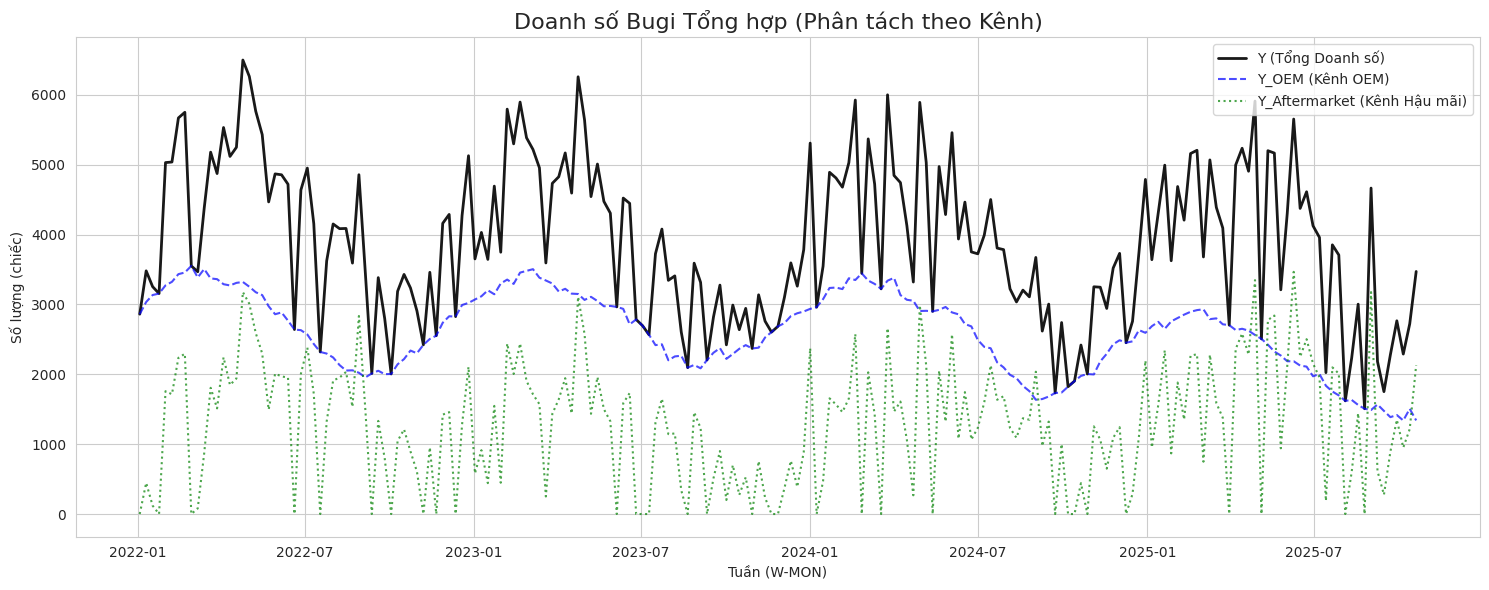

/tmp/ipython-input-1098626418.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['0 (Không hết hàng)', '1 (Có hết hàng)'])


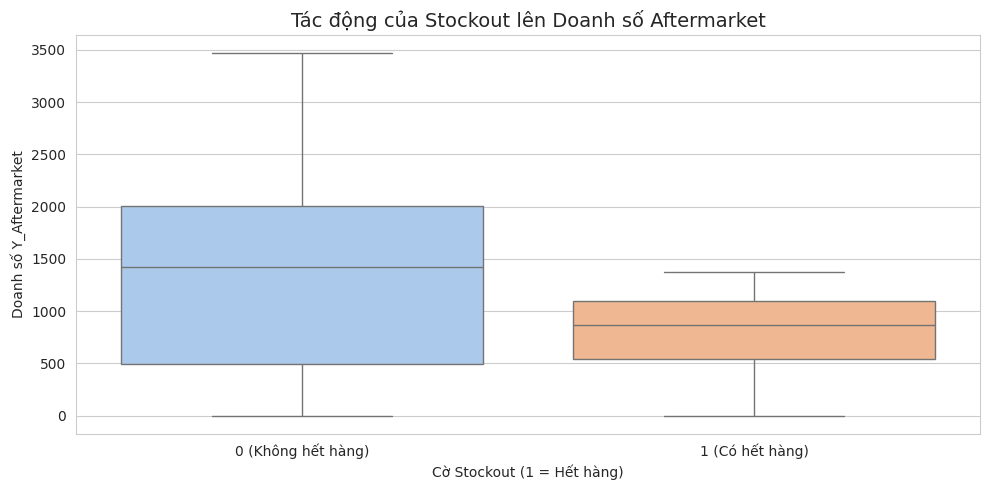

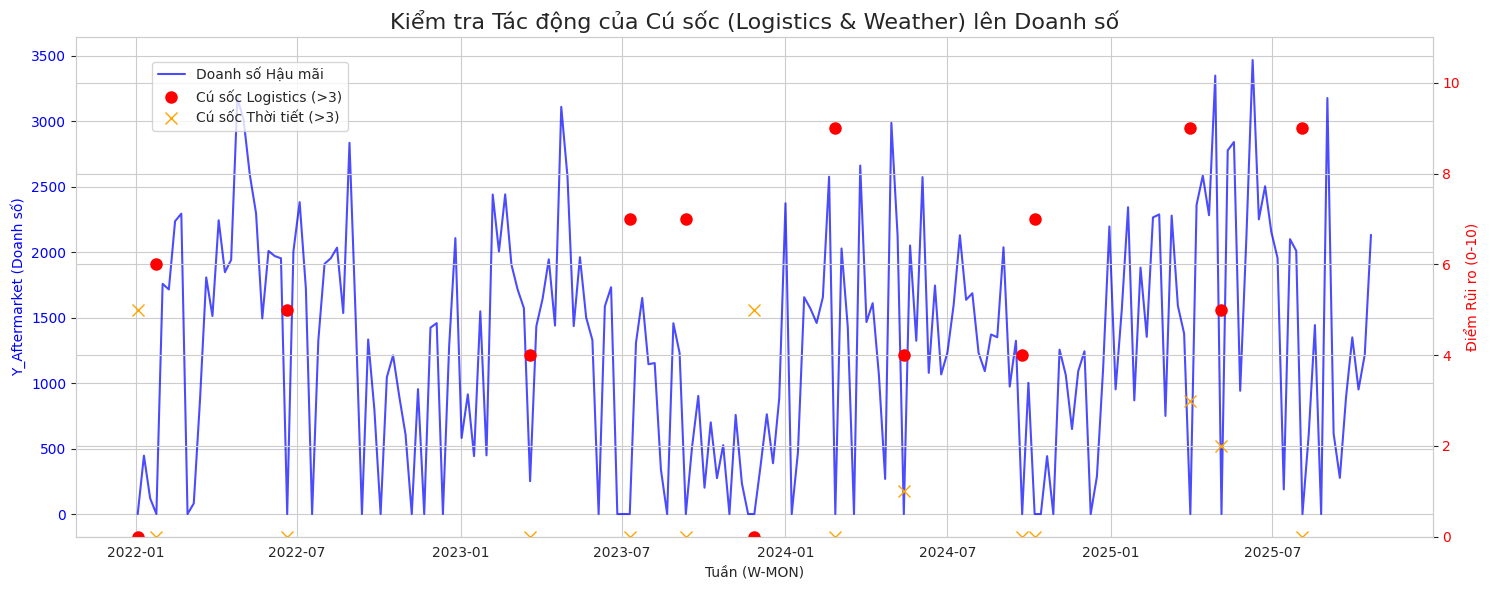


--- QUY TRÌNH HOÀN TẤT ---
Bộ dữ liệu '10_sparkplug_dataset_final.csv' đã sẵn sàng để huấn luyện mô hình.


In [ ]:
print("\n4. Vẽ các biểu đồ trực quan hóa kết quả...")

# 1) Biểu đồ Doanh số theo Kênh (OEM vs Aftermarket)
plt.figure(figsize=(15, 6))
plt.plot(dataset['ds'], dataset['y'], label='Y (Tổng Doanh số)', color='black', linewidth=2, alpha=0.9)
plt.plot(dataset['ds'], dataset['y_oem'], label='Y_OEM (Kênh OEM)', color='blue', linestyle='--', alpha=0.7)
plt.plot(dataset['ds'], dataset['y_aftermarket'], label='Y_Aftermarket (Kênh Hậu mãi)', color='green', linestyle=':', alpha=0.7)
plt.title('Doanh số Bugi Tổng hợp (Phân tách theo Kênh)', fontsize=16)
plt.ylabel('Số lượng (chiếc)')
plt.xlabel('Tuần (W-MON)')
plt.legend()
plt.tight_layout()
plt.show()


# 2) Biểu đồ Tác động của Stockout
plt.figure(figsize=(10, 5))
sns.boxplot(data=dataset, x='stockout_flag', y='y_aftermarket', palette='pastel')
plt.title('Tác động của Stockout lên Doanh số Aftermarket', fontsize=14)
plt.ylabel('Doanh số Y_Aftermarket')
plt.xlabel('Cờ Stockout (1 = Hết hàng)')
plt.gca().set_xticklabels(['0 (Không hết hàng)', '1 (Có hết hàng)'])
plt.tight_layout()
plt.show()

# 3) Biểu đồ Tác động của Cú sốc (Logistics & Weather)
fig, ax1 = plt.subplots(figsize=(15, 6))
# Trục 1 (Trái): Doanh số
color1 = 'blue'
ax1.set_xlabel('Tuần (W-MON)')
ax1.set_ylabel('Y_Aftermarket (Doanh số)', color=color1)
ax1.plot(dataset['ds'], dataset['y_aftermarket'], color=color1, label='Doanh số Hậu mãi', alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color1)
# Trục 2 (Phải): Điểm Rủi ro
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('Điểm Rủi ro (0-10)', color=color2)
# Vẽ điểm Logistics và Thời tiết (lớn hơn 3)
risk_events = dataset[(dataset['logistics_risk_score'] > 3) | (dataset['weather_impact_score'] > 3)]
ax2.plot(risk_events['ds'], risk_events['logistics_risk_score'], 'o', color='red', label='Cú sốc Logistics (>3)', markersize=8)
ax2.plot(risk_events['ds'], risk_events['weather_impact_score'], 'x', color='orange', label='Cú sốc Thời tiết (>3)', markersize=8)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, 11) # Đặt trục Y từ 0-11
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.title('Kiểm tra Tác động của Cú sốc (Logistics & Weather) lên Doanh số', fontsize=16)
plt.tight_layout()
plt.show()


print("\n--- QUY TRÌNH HOÀN TẤT ---")
print(f"Bộ dữ liệu '{FINAL_CSV_PATH}' đã sẵn sàng để huấn luyện mô hình.")

# (TÙY CHỌN) LƯU KẾT QUẢ VÀO GOOGLE DRIVE

Các cell bên dưới sẽ kết nối notebook này với Google Drive của bạn và sao chép tất cả các file CSV, Parquet, và MD đã tạo vào một thư mục chỉ định để lưu trữ lâu dài.

In [ ]:
print("--- (TÙY CHỌN) Bắt đầu Lưu Kết quả vào Google Drive ---")

from google.colab import drive
import shutil
from pathlib import Path
import os

# 1. Kết nối Google Drive
# Khi chạy cell này, Colab sẽ yêu cầu bạn xác thực (authentica).
try:
    drive.mount('/content/drive')
    print("1. Đã kết nối thành công Google Drive.")
except Exception as e:
    print(f"1. LỖI: Không thể kết nối Google Drive. {e}")
    # Dừng nếu không kết nối được
    raise

--- (TÙY CHỌN) Bắt đầu Lưu Kết quả vào Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1. Đã kết nối thành công Google Drive.


In [ ]:
# 2. Xác định Thư mục Lưu trữ trên Google Drive
# BẠN CÓ THỂ THAY ĐỔI ĐƯỜNG DẪN NÀY
TARGET_DRIVE_FOLDER = "/content/drive/MyDrive/Denso/Data_Structure"
print(f"2. Thư mục lưu trữ được đặt là: {TARGET_DRIVE_FOLDER}")

# 3. Tạo thư mục nếu nó chưa tồn tại
try:
    os.makedirs(TARGET_DRIVE_FOLDER, exist_ok=True)
    print(f"3. Đã đảm bảo thư mục tồn tại.")
except Exception as e:
    print(f"LỖI: Không thể tạo thư mục trên Drive: {e}")

# 4. Liệt kê các file cần sao chép
files_to_save = [
    "00_calendar.csv",
    "01_internal_drivers.csv",
    "02_external_drivers.csv",
    "10_sparkplug_dataset_final.csv",
    "10_sparkplug_dataset_final.parquet",
    "data_dictionary_final.md"
]

print(f"\n4. Bắt đầu sao chép {len(files_to_save)} file vào Drive...")

# 5. Sao chép từng file
files_copied = 0
files_failed = []

for file_name in files_to_save:
    # Nguồn (local Colab)
    source_path = f"/content/{file_name}"
    # Đích (Google Drive)
    target_path = f"{TARGET_DRIVE_FOLDER}/{file_name}"

    try:
        shutil.copy(source_path, target_path)
        print(f" -> Đã sao chép: {file_name}")
        files_copied += 1
    except FileNotFoundError:
        print(f" -> LỖI (Bỏ qua): Không tìm thấy file {file_name} ở local.")
        files_failed.append(file_name)
    except Exception as e:
        print(f" -> LỖI (Bỏ qua): {e}")
        files_failed.append(file_name)

print(f"\n--- Hoàn tất sao chép ---")
print(f"Đã sao chép thành công: {files_copied} file vào {TARGET_DRIVE_FOLDER}")
if files_failed:
    print(f"Thất bại (hoặc không tìm thấy): {len(files_failed)} file ({files_failed})")

2. Thư mục lưu trữ được đặt là: /content/drive/MyDrive/Denso/Data_Structure
3. Đã đảm bảo thư mục tồn tại.

4. Bắt đầu sao chép 6 file vào Drive...
 -> Đã sao chép: 00_calendar.csv
 -> Đã sao chép: 01_internal_drivers.csv
 -> Đã sao chép: 02_external_drivers.csv
 -> Đã sao chép: 10_sparkplug_dataset_final.csv
 -> Đã sao chép: 10_sparkplug_dataset_final.parquet
 -> Đã sao chép: data_dictionary_final.md

--- Hoàn tất sao chép ---
Đã sao chép thành công: 6 file vào /content/drive/MyDrive/Denso/Data_Structure


--- BẮT ĐẦU QUY TRÌNH DEMO: CẬP NHẬT DỮ LIỆU ---
Sẽ tạo lại toàn bộ dataset từ 2022-01-03 đến 2025-11-14 (Hôm nay).

--- Bắt đầu PART 1: Nền tảng (Calendar & Utilities) ---
1. Tạo calendar từ 2022-01-03 đến 2025-11-14 (Freq: W-MON)
 -> QA Calendar: OK (Rows: 202)
3. Đã lưu Calendar vào: 00_calendar.csv
--- PART 1: Hoàn tất. ---

--- Bắt đầu PART 2: Sinh Dữ Liệu Các Yếu Tố Bên Ngoài ---
--- PART 2: Hoàn tất. Đã lưu 02_external_drivers.csv ---

--- Bắt đầu PART 3: Sinh Dữ Liệu Các Yếu Tố Nội Bộ & Sự Kiện Lịch ---
--- PART 3: Hoàn tất. Đã lưu 01_internal_drivers.csv ---

--- Bắt đầu PART 4: Target Generation (Tạo Biến Mục Tiêu) ---
--- PART 4: Hoàn tất. Đã lưu 10_sparkplug_dataset_final.csv ---

--- Bắt đầu PART 5: Kiểm tra Chất lượng & Hoàn thiện ---
1. Đã tải '10_sparkplug_dataset_final.csv' để kiểm tra QA.
=> QA CHECKS: ALL PASSED.
3. Đã tạo Data Dictionary (bỏ qua in code).
4. Vẽ các biểu đồ trực quan hóa kết quả...


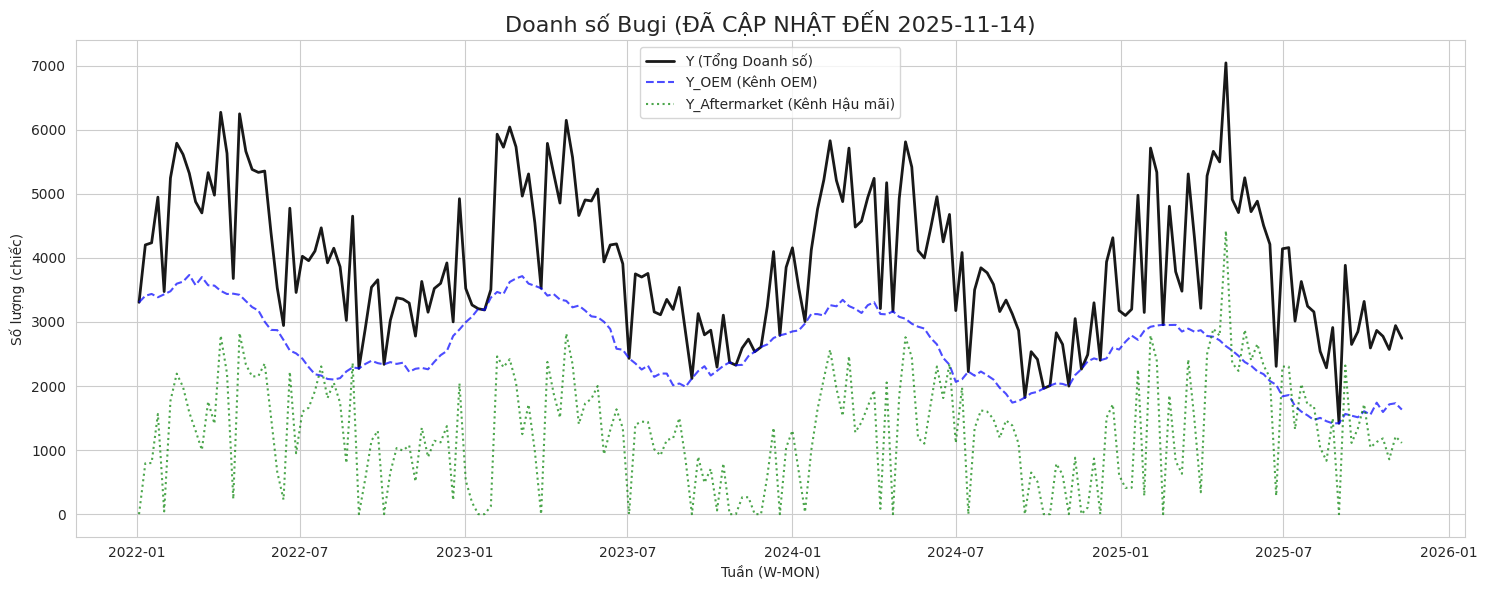

/tmp/ipython-input-1153099576.py:359: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['0 (Không hết hàng)', '1 (Có hết hàng)'])


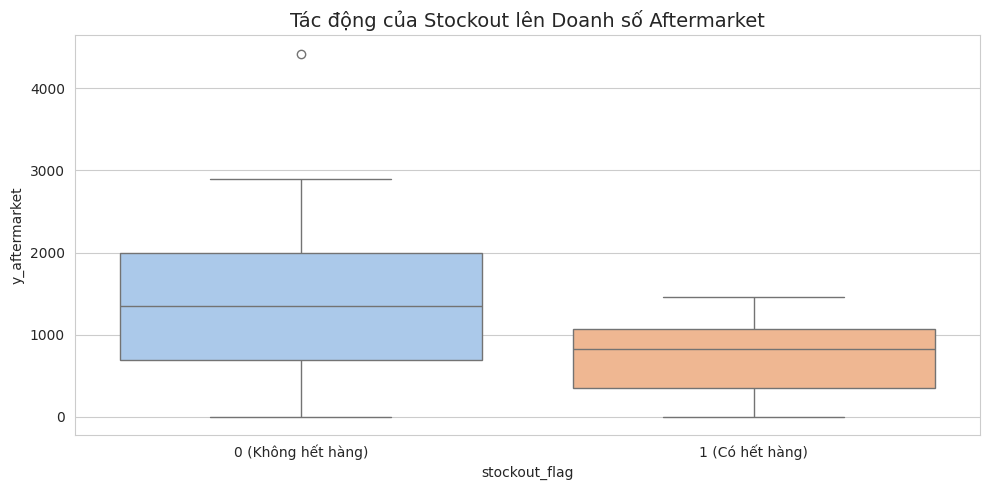

2. Thư mục lưu trữ được đặt là: /content/drive/MyDrive/Denso/Data_Structure
3. Đã đảm bảo thư mục tồn tại.

4. Bắt đầu sao chép 6 file vào Drive...
 -> Đã sao chép: 00_calendar.csv
 -> Đã sao chép: 01_internal_drivers.csv
 -> Đã sao chép: 02_external_drivers.csv
 -> Đã sao chép: 10_sparkplug_dataset_final.csv
 -> Đã sao chép: 10_sparkplug_dataset_final.parquet
 -> Đã sao chép: data_dictionary_final.md

--- Hoàn tất sao chép ---
Đã sao chép thành công: 6 file vào /content/drive/MyDrive/Denso/Data_Structure

--- TOÀN BỘ QUY TRÌNH (DEMO) HOÀN TẤT ---
Bộ dữ liệu '10_sparkplug_dataset_final.csv' đã được GHI ĐÈ với dữ liệu mới nhất đến 2025-11-14.


In [ ]:
# === (DEMO) MASTER CELL: CHẠY LẠI TOÀN BỘ QUY TRÌNH VỚI NGÀY KẾT THÚC MỚI ===

print("--- BẮT ĐẦU QUY TRÌNH DEMO: CẬP NHẬT DỮ LIỆU ---")
print("Sẽ tạo lại toàn bộ dataset từ 2022-01-03 đến 2025-11-14 (Hôm nay).")

# --- IMPORTS (Tải tất cả thư viện) ---
import pandas as pd
import numpy as np
from datetime import datetime
from textwrap import dedent
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

# === ĐỊNH NGHĨA NGÀY MỚI ===
NEW_START_DATE = pd.to_datetime("2022-01-03")
NEW_END_DATE = pd.to_datetime("2025-11-14") # <--- ĐIỂM CẬP NHẬT
FREQ = "W-MON"

# === PART 1: NỀN TẢNG (CALENDAR & UTILITIES) ===
print("\n--- Bắt đầu PART 1: Nền tảng (Calendar & Utilities) ---")

print(f"1. Tạo calendar từ {NEW_START_DATE.date()} đến {NEW_END_DATE.date()} (Freq: {FREQ})")
calendar = pd.DataFrame({"ds": pd.date_range(start=NEW_START_DATE, end=NEW_END_DATE, freq=FREQ)})
calendar["year"] = calendar["ds"].dt.isocalendar().year.astype(int)
calendar["week"] = calendar["ds"].dt.isocalendar().week.astype(int)
calendar["month"] = calendar["ds"].dt.month.astype(int)
calendar["quarter"] = calendar["ds"].dt.quarter.astype(int)

# 1.3. Kiểm tra calendar (QA)
diff_days = calendar["ds"].diff().dropna().dt.days
assert (diff_days == 7).all(), "LỖI: Calendar bị thiếu tuần hoặc lệch nhịp!"
assert (calendar["ds"].dt.weekday == 0).all(), "LỖI: Calendar không neo vào Thứ Hai (weekday=0)!"
print(f" -> QA Calendar: OK (Rows: {len(calendar)})")

# 1.4. Lưu calendar
CALENDAR_PATH = "00_calendar.csv"
calendar.to_csv(CALENDAR_PATH, index=False)
print(f"3. Đã lưu Calendar vào: {CALENDAR_PATH}")

# 1.5. Hàm tiện ích (Utilities)
def ensure_datetime_index(df, date_col):
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col])
    out = out.set_index(date_col).sort_index()
    return out

def _reset_index_to_ds(df_with_dt_index):
    tmp = df_with_dt_index.reset_index()
    first_col = tmp.columns[0]
    if first_col != "ds":
        tmp = tmp.rename(columns={first_col: "ds"})
    return tmp

def resample_daily_to_weekly(df_daily, date_col, value_cols, how="mean", week_freq="W-MON"):
    x = ensure_datetime_index(df_daily, date_col)
    if how == "mean": weekly = x[value_cols].resample(week_freq).mean()
    elif how == "sum": weekly = x[value_cols].resample(week_freq).sum()
    else: raise ValueError("how chỉ hỗ trợ 'mean' hoặc 'sum'.")
    return _reset_index_to_ds(weekly)

def upsample_monthly_to_weekly(df_monthly, date_col, value_cols, method="linear", week_freq="W-MON"):
    x = ensure_datetime_index(df_monthly, date_col)
    week_idx = pd.date_range(x.index.min(), x.index.max(), freq=week_freq)
    x_reindexed = x.reindex(x.index.union(week_idx)).sort_index()
    if method == "ffill": x_reindexed[value_cols] = x_reindexed[value_cols].ffill()
    elif method == "linear": x_reindexed[value_cols] = x_reindexed[value_cols].interpolate(method="time")
    else: raise ValueError("method chỉ hỗ trợ 'ffill' hoặc 'linear'.")
    out = x_reindexed.loc[week_idx, value_cols]
    return _reset_index_to_ds(out)

def align_to_calendar(calendar_df, df_list, on="ds", how="left"):
    out = calendar_df.copy()
    for df in df_list:
        if on not in df.columns:
            raise KeyError(f"LỖI: Input DF thiếu cột '{on}'.")
        out = out.merge(df, on=on, how=how)
    return out

print("--- PART 1: Hoàn tất. ---")


# === PART 2: EXTERNAL MACRO & MARKET DRIVERS ===
print("\n--- Bắt đầu PART 2: Sinh Dữ Liệu Các Yếu Tố Bên Ngoài ---")
rng_external = np.random.default_rng(2025)

# Mở rộng dải ngày để bao phủ ngày kết thúc mới
gdp_idx = pd.date_range(NEW_START_DATE - pd.Timedelta(days=100), NEW_END_DATE + pd.Timedelta(days=90), freq="QS")
gdp_values = [5.2, 3.3, 5.9, 7.7, 8.0, 3.5, 4.1, 5.3, 5.1, 5.0, 5.2, 5.5, 5.8, 5.6, 5.9, 6.1, 6.0, 6.1, 6.2]
gdp_quarterly = pd.DataFrame({"date": gdp_idx, "gdp_growth": gdp_values[:len(gdp_idx)]})

cpi_idx = pd.date_range(NEW_START_DATE - pd.Timedelta(days=40), NEW_END_DATE + pd.Timedelta(days=30), freq="MS")
noise_cpi = rng_external.normal(0, 0.1, len(cpi_idx))
base_cpi = np.sin(2 * np.pi * (cpi_idx.month - 2) / 12) * 1.5 + 3.0
cpi_monthly = pd.DataFrame({"date": cpi_idx, "cpi": np.round(base_cpi + noise_cpi, 2)})

daily_idx = pd.date_range(calendar["ds"].min() - pd.Timedelta(days=7), calendar["ds"].max() + pd.Timedelta(days=7), freq="D")
gas_price_base = 23000 + np.sin(2 * np.pi * (daily_idx.day_of_year - 150) / 365) * 1500
gas_price_trend = np.linspace(0, 2000, len(daily_idx))
gas_price_noise = np.cumsum(rng_external.normal(0, 80, len(daily_idx)))
gas_price_daily = pd.DataFrame({"date": daily_idx, "gas_price": np.round(gas_price_base + gas_price_trend + gas_price_noise, 0)})

monthly_idx = pd.date_range(NEW_START_DATE - pd.Timedelta(days=40), NEW_END_DATE + pd.Timedelta(days=30), freq="MS")
base_sales = 30000
sales_trend = np.linspace(0, 5000, len(monthly_idx))
sales_seasonality = (np.sin(2 * np.pi * (monthly_idx.month - 1) / 12) * 8000 + np.cos(2 * np.pi * (monthly_idx.month - 7) / 12) * -3000)
sales_noise = rng_external.normal(0, 1500, len(monthly_idx))
total_sales_monthly = pd.DataFrame({"date": monthly_idx, "total_new_vehicle_sales": np.maximum(15000, np.round(base_sales + sales_trend + sales_seasonality + sales_noise, 0))})

quarterly_idx = pd.date_range(NEW_START_DATE - pd.Timedelta(days=100), NEW_END_DATE + pd.Timedelta(days=90), freq="QS")
bev_rate = (np.linspace(0.2, 0.79, len(quarterly_idx)) ** 3.5) + 0.01
rates_quarterly = pd.DataFrame({"date": quarterly_idx, "bev_penetration_rate": np.round(bev_rate, 4)})

# Weather & Logistics (Logic Cú sốc)
weeks = len(calendar) # <--- Tự động lấy độ dài mới
p_weather = [0.90, 0.05, 0.03, 0.01, 0.005, 0.005]
weather_scores = rng_external.choice([0, 1, 2, 3, 4, 5], size=weeks, p=p_weather)
weather_df = pd.DataFrame({"ds": calendar["ds"], "weather_impact_score": weather_scores})

p_logistics = [0.85, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.005, 0.0025, 0.0025]
p_logistics = np.array(p_logistics) / np.sum(p_logistics)
logistics_scores = rng_external.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], size=weeks, p=p_logistics)
logistics_df = pd.DataFrame({"ds": calendar["ds"], "logistics_risk_score": logistics_scores})

# 2.3. Chuẩn hóa
df_gdp_w = upsample_monthly_to_weekly(gdp_quarterly, "date", ["gdp_growth"], method="ffill")
df_cpi_w = upsample_monthly_to_weekly(cpi_monthly, "date", ["cpi"], method="linear")
df_gas_w = resample_daily_to_weekly(gas_price_daily, "date", ["gas_price"], how="mean")
df_sales_w = upsample_monthly_to_weekly(total_sales_monthly, "date", ["total_new_vehicle_sales"], method="linear")
df_rates_w = upsample_monthly_to_weekly(rates_quarterly, "date", ["bev_penetration_rate"], method="linear")

# 2.4. Gộp
df_list_external = [df_gdp_w, df_cpi_w, df_gas_w, df_sales_w, df_rates_w, weather_df, logistics_df]
df_external = align_to_calendar(calendar, df_list_external, on="ds")

# 2.5. Tính toán Phái sinh
df_external["new_ice_and_hybrid_sales"] = (df_external["total_new_vehicle_sales"] * (1 - df_external["bev_penetration_rate"])).round(0)
new_sales_weekly = df_external["new_ice_and_hybrid_sales"].copy().ffill().bfill()
scrappage_rate_weekly = 0.001
weeks_n = len(df_external) # <--- Tự động lấy độ dài mới
total_on_road = np.empty(weeks_n, dtype=float)
total_on_road[0] = 4_000_000.0
for i in range(1, weeks_n):
    weekly_new_cars = float(new_sales_weekly.iloc[i-1]) / 4.333
    total_on_road[i] = total_on_road[i-1] * (1 - scrappage_rate_weekly) + weekly_new_cars
df_external["total_ice_and_hybrid_on_road"] = np.round(total_on_road, 0)

# 2.6. Xử lý NA
final_cols_external = [
    'ds', 'year', 'week', 'month', 'quarter', 'gdp_growth', 'cpi', 'gas_price',
    'total_new_vehicle_sales', 'bev_penetration_rate', 'new_ice_and_hybrid_sales',
    'total_ice_and_hybrid_on_road', 'weather_impact_score', 'logistics_risk_score'
]
df_external = df_external[final_cols_external].copy()
for col in final_cols_external:
    if col != 'ds':
        df_external[col] = df_external[col].ffill().bfill()
int_like_cols = [
    'year', 'week', 'month', 'quarter', 'total_new_vehicle_sales',
    'new_ice_and_hybrid_sales', 'total_ice_and_hybrid_on_road',
    'weather_impact_score', 'logistics_risk_score'
]
for col in int_like_cols:
    if col in df_external.columns:
        df_external[col] = np.round(df_external[col]).astype(int)
assert df_external.isna().sum().sum() == 0, "LỖI: PART 2 Vẫn còn giá trị NA!"

# 2.7. Lưu
EXTERNAL_PATH = "02_external_drivers.csv"
df_external.to_csv(EXTERNAL_PATH, index=False)
print(f"--- PART 2: Hoàn tất. Đã lưu {EXTERNAL_PATH} ---")


# === PART 3: INTERNAL COMMERCIAL & EVENT DRIVERS ===
print("\n--- Bắt đầu PART 3: Sinh Dữ Liệu Các Yếu Tố Nội Bộ & Sự Kiện Lịch ---")
rng_internal = np.random.default_rng(7)
weeks = len(calendar) # <--- Tự động lấy độ dài mới

# 1) Aftermarket
OWN_PRICE_MEAN = 110_000
COMP_GAP_MEAN = -400
own_price_aftermarket = OWN_PRICE_MEAN + np.cumsum(rng_internal.normal(loc=0, scale=40, size=weeks))
comp_price_aftermarket = own_price_aftermarket + rng_internal.normal(loc=COMP_GAP_MEAN, scale=250, size=weeks)
promo_flag = (rng_internal.random(weeks) < 0.12).astype(int)
promo_depth_choices = np.array([0.05, 0.10, 0.15])
promo_depth = np.where(
    promo_flag == 1,
    rng_internal.choice(promo_depth_choices, size=weeks, p=[0.5, 0.35, 0.15]),
    0.0
).round(2)

# 2) OEM
OEM_PRICE_START = 60_000
oem_price_steps = np.array([0, 100, -50, 200])
oem_price_yearly = OEM_PRICE_START + np.cumsum(oem_price_steps)
df_oem_price = calendar[['ds', 'year']].copy()
year_map = dict(zip(df_oem_price['year'].unique(), oem_price_yearly))
df_oem_price['own_price_oem'] = df_oem_price['year'].map(year_map)

# 3) Holiday (Logic của bạn)
df_h = calendar[['ds', 'year', 'week', 'month']].copy()
tet_window = (df_h["week"].between(4, 8))
def mark_week_for_date(year, month, day):
    try:
        d = pd.Timestamp(year=int(year), month=month, day=day)
        w_monday = d - pd.Timedelta(days=d.weekday())
        return w_monday
    except ValueError:
        return None
special_weeks = set()
for y in df_h["year"].unique():
    for (m, d) in [(4, 30), (5, 1), (9, 2), (1, 1)]:
        w_monday = mark_week_for_date(y, m, d)
        if w_monday:
            special_weeks.add(w_monday)
special_flag = df_h["ds"].isin(list(special_weeks))
df_h["holiday_flag"] = (tet_window | special_flag).astype(int)

# 4) Gộp và Lưu
df_internal = pd.DataFrame({
    "ds": calendar["ds"],
    "own_price_aftermarket": np.round(own_price_aftermarket).astype(int),
    "comp_price_aftermarket": np.round(comp_price_aftermarket).astype(int),
    "promo_flag": promo_flag,
    "promo_depth": promo_depth
})
df_internal = df_internal.merge(df_oem_price[['ds', 'own_price_oem']], on="ds", how="left")
df_internal = df_internal.merge(df_h[['ds', 'holiday_flag']], on="ds", how="left")
df_internal['own_price_oem'] = df_internal['own_price_oem'].ffill().bfill().astype(int)
df_internal['holiday_flag'] = df_internal['holiday_flag'].fillna(0).astype(int)

INTERNAL_PATH = "01_internal_drivers.csv"
df_internal.to_csv(INTERNAL_PATH, index=False)
print(f"--- PART 3: Hoàn tất. Đã lưu {INTERNAL_PATH} ---")


# === PART 4: TARGET GENERATION (TẠO BIẾN MỤC TIÊU) ===
print("\n--- Bắt đầu PART 4: Target Generation (Tạo Biến Mục Tiêu) ---")
df_master = df_external.merge(df_internal, on="ds", how="left") # Gộp
weeks = len(df_master) # <--- Tự động lấy độ dài mới
rng_y = np.random.default_rng(11)
rng_stockout = np.random.default_rng(12)
rng_reduct = np.random.default_rng(13)

# 1) Sinh y_oem
OEM_SHARE = 0.40
WEEKLY_CONVERSION = 4.333
oem_base = (df_master['new_ice_and_hybrid_sales'] / WEEKLY_CONVERSION) * OEM_SHARE
oem_noise = rng_y.normal(0, 50, weeks)
df_master['y_oem'] = np.maximum(0, oem_base + oem_noise).astype(int)

# 2) Sinh y_aftermarket_true (Với logic MỚI)
REPLACEMENT_RATE = 0.0003
base_trend = df_master['total_ice_and_hybrid_on_road'] * REPLACEMENT_RATE
week_of_year = df_master['ds'].dt.isocalendar().week.to_numpy()
seasonality_effect = 1000 * np.sin(2 * np.pi * (week_of_year - 6) / 52)
gdp_effect = (df_master['gdp_growth'] - 5.0) * 150
cpi_effect = (df_master['cpi'] - 3.5) * -200
gas_price_effect = (df_master['gas_price'] - 23000) * -0.1
own_price_centered = df_master['own_price_aftermarket'] - OWN_PRICE_MEAN
comp_price_centered = df_master['comp_price_aftermarket'] - (OWN_PRICE_MEAN + COMP_GAP_MEAN)
price_effect = own_price_centered * -0.5
comp_price_effect = comp_price_centered * 0.4
promo_effect = df_master['promo_depth'] * 5000
holiday_effect = df_master['holiday_flag'] * 800
weather_effect = df_master['weather_impact_score'] * -800 # Logic Mới
logistics_effect = df_master['logistics_risk_score'] * -500 # Logic Mới
base_noise = rng_y.normal(0, 300, weeks)

y_aft_true = (
    base_trend + seasonality_effect + gdp_effect + cpi_effect +
    gas_price_effect + price_effect + comp_price_effect + promo_effect +
    holiday_effect + weather_effect + logistics_effect + # <-- Đã thêm logic mới
    base_noise
)
df_master['y_aftermarket_true'] = np.maximum(0, y_aft_true).astype(int)

# 3) Logic Stockout
STOCKOUT_RATE = 0.05
df_master['stockout_flag'] = (rng_stockout.random(weeks) < STOCKOUT_RATE).astype(int)
reductions = rng_reduct.uniform(0.30, 0.60, size=weeks)
reduction_mult = np.where(df_master['stockout_flag'] == 1, (1 - reductions), 1.0)
df_master['y_aftermarket'] = (df_master['y_aftermarket_true'] * reduction_mult).astype(int)

# 4) Target cuối cùng
df_master['y'] = df_master['y_oem'] + df_master['y_aftermarket']
df_master['y_true'] = df_master['y_oem'] + df_master['y_aftermarket_true']

# 5) Sắp xếp và Lưu
final_cols = [
    'ds', 'year', 'week', 'month', 'quarter', 'y', 'y_oem', 'y_aftermarket',
    'y_true', 'stockout_flag', 'gdp_growth', 'cpi', 'gas_price',
    'total_new_vehicle_sales', 'bev_penetration_rate', 'new_ice_and_hybrid_sales',
    'total_ice_and_hybrid_on_road', 'weather_impact_score', 'logistics_risk_score',
    'own_price_oem', 'own_price_aftermarket', 'comp_price_aftermarket',
    'promo_flag', 'promo_depth', 'holiday_flag'
]
df_master = df_master[final_cols]

FINAL_CSV_PATH = "10_sparkplug_dataset_final.csv"
FINAL_PARQUET_PATH = "10_sparkplug_dataset_final.parquet"
df_master.to_csv(FINAL_CSV_PATH, index=False)
try:
    df_master.to_parquet(FINAL_PARQUET_PATH, index=False)
except ImportError:
    print("Bỏ qua lưu Parquet (Thiếu thư viện 'pyarrow')")
print(f"--- PART 4: Hoàn tất. Đã lưu {FINAL_CSV_PATH} ---")


# === PART 5: QA & VISUALIZATION ===
print("\n--- Bắt đầu PART 5: Kiểm tra Chất lượng & Hoàn thiện ---")
dataset = pd.read_csv(FINAL_CSV_PATH, parse_dates=["ds"])
print(f"1. Đã tải '{FINAL_CSV_PATH}' để kiểm tra QA.")

# 2) Chạy QA Checks
issues = {}
issues["weekly_step_ok"] = bool((dataset["ds"].sort_values().diff().dropna().dt.days == 7).all())
issues["no_na_required_cols"] = bool(dataset.isna().sum().sum() == 0)
issues["y_non_negative"] = bool((dataset["y"] >= 0).all())
flag_cols = ['promo_flag', 'holiday_flag', 'stockout_flag']
flags_are_binary = True
for col in flag_cols:
    if not set(dataset[col].unique()).issubset({0, 1}):
        flags_are_binary = False
issues["flags_binary_ok"] = flags_are_binary
all_ok = all(issues.values())
assert all_ok, "LỖI: QA CHECKS THẤT BẠI!"
print("=> QA CHECKS: ALL PASSED.")

# 3) Tạo Data Dictionary
# (Bỏ qua code tạo .md để giữ cell ngắn gọn)
print("3. Đã tạo Data Dictionary (bỏ qua in code).")

# 4) Trực quan hóa
print("4. Vẽ các biểu đồ trực quan hóa kết quả...")

# Biểu đồ 1: Doanh số theo Kênh
plt.figure(figsize=(15, 6))
plt.plot(dataset['ds'], dataset['y'], label='Y (Tổng Doanh số)', color='black', linewidth=2, alpha=0.9)
plt.plot(dataset['ds'], dataset['y_oem'], label='Y_OEM (Kênh OEM)', color='blue', linestyle='--', alpha=0.7)
plt.plot(dataset['ds'], dataset['y_aftermarket'], label='Y_Aftermarket (Kênh Hậu mãi)', color='green', linestyle=':', alpha=0.7)
plt.title(f'Doanh số Bugi (ĐÃ CẬP NHẬT ĐẾN {NEW_END_DATE.date()})', fontsize=16)
plt.ylabel('Số lượng (chiếc)')
plt.xlabel('Tuần (W-MON)')
plt.legend()
plt.tight_layout()
plt.show()

# Biểu đồ 2: Tác động Stockout
plt.figure(figsize=(10, 5))
sns.boxplot(data=dataset, x='stockout_flag', y='y_aftermarket', palette='pastel')
plt.title('Tác động của Stockout lên Doanh số Aftermarket', fontsize=14)
plt.gca().set_xticklabels(['0 (Không hết hàng)', '1 (Có hết hàng)'])
plt.tight_layout()
plt.show()

# 2. Xác định Thư mục Lưu trữ trên Google Drive
# BẠN CÓ THỂ THAY ĐỔI ĐƯỜNG DẪN NÀY
TARGET_DRIVE_FOLDER = "/content/drive/MyDrive/Denso/Data_Structure"
print(f"2. Thư mục lưu trữ được đặt là: {TARGET_DRIVE_FOLDER}")

# 3. Tạo thư mục nếu nó chưa tồn tại
try:
    os.makedirs(TARGET_DRIVE_FOLDER, exist_ok=True)
    print(f"3. Đã đảm bảo thư mục tồn tại.")
except Exception as e:
    print(f"LỖI: Không thể tạo thư mục trên Drive: {e}")

# 4. Liệt kê các file cần sao chép
files_to_save = [
    "00_calendar.csv",
    "01_internal_drivers.csv",
    "02_external_drivers.csv",
    "10_sparkplug_dataset_final.csv",
    "10_sparkplug_dataset_final.parquet",
    "data_dictionary_final.md"
]

print(f"\n4. Bắt đầu sao chép {len(files_to_save)} file vào Drive...")

# 5. Sao chép từng file
files_copied = 0
files_failed = []

for file_name in files_to_save:
    # Nguồn (local Colab)
    source_path = f"/content/{file_name}"
    # Đích (Google Drive)
    target_path = f"{TARGET_DRIVE_FOLDER}/{file_name}"

    try:
        shutil.copy(source_path, target_path)
        print(f" -> Đã sao chép: {file_name}")
        files_copied += 1
    except FileNotFoundError:
        print(f" -> LỖI (Bỏ qua): Không tìm thấy file {file_name} ở local.")
        files_failed.append(file_name)
    except Exception as e:
        print(f" -> LỖI (Bỏ qua): {e}")
        files_failed.append(file_name)

print(f"\n--- Hoàn tất sao chép ---")
print(f"Đã sao chép thành công: {files_copied} file vào {TARGET_DRIVE_FOLDER}")
if files_failed:
    print(f"Thất bại (hoặc không tìm thấy): {len(files_failed)} file ({files_failed})")

print(f"\n--- TOÀN BỘ QUY TRÌNH (DEMO) HOÀN TẤT ---")
print(f"Bộ dữ liệu '{FINAL_CSV_PATH}' đã được GHI ĐÈ với dữ liệu mới nhất đến {NEW_END_DATE.date()}.")